In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pandas as pd
from tqdm import trange
import os
import time
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import datetime
import warnings
from IPython.external import mathjax
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Activation, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import tensorflow as tf 
import io
import imutils
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

print("Using tensorflow version:", tensorflow.keras.__version__)

Using tensorflow version: 2.4.0


In [2]:
in_google = True

if in_google:
    from google.colab import drive
    drive.mount("/content/drive")
DATADIR = "/content/drive/MyDrive/astro_128/"

Mounted at /content/drive


In [3]:
from google.colab import files
uploaded = files.upload()

In [4]:
!unzip -q /content/drive/MyDrive/astro_128/reduced_training_images.zip -d . 
!tar -xf /content/drive/MyDrive/astro_128/training_images.tar -C .
print("done!")

done!


To start becoming familiar with galaxy classification, we will start with trying to classify some of the galaxies on [GalaxyZoo/Classify](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/classify). The classification scheme for a galaxy with noticable structure is as follows: 
1. Identify whether the galaxy is smooth and featureless, or if there is some noticable structure. 

2. Determine if the galaxy could be a disk that is viewed edge-on

3. Determine if there is a bar going through the center of the galaxy

4. Determine if there is a spiral ar pattern

5. Determine if there is a bulge, and if so how big it is

6. Determine if the galaxy is merging or disturbed

7. Note any other additional/rare features such as a ring, gravitational lensing, dust lanes, or overlap with another object

For a smooth galaxy, the classification scheme is as follows:

1. Identify whether the galaxy is smooth and featureless, or if there is some noticable structure. 

2. Determine if the galaxy is round, cigar shaped, or somewhere in between

3. Determine if the galaxy is merging or disrurbed

4. Note any other additional/rare features such as a ring, gravitational lensing, dust lanes, or overlap with another object

When constructing the dataset for the Galaxy Zoo 2 (GZ2), cuts it was necessary to make cuts in the data to have high quality images to use to make classifications with. In order to have galaxies that are large enough to resolve and classify, a cut on the angular size was made, keeping only stars with an angular radius `petroR90` of 3 arcseconds, which contains 90% of the luminosity in the r-band. Additionally, galaxies with resdhifts within the range of 0.0005 < z < 0.25 were kept, along with galaxies with no reported redshift. Lastly, onjects which were flagged by the SDSS pipeline as `SATURATED`, `BRIGHT`, or `BLENDED` without the `NODEBLEND` flag were discarded. These cuts resulted in an original samle of 245,609 glaxies [Willet et al. 2013 Section 2.1](https://arxiv.org/abs/1308.3496). 

The images generated from the SDSS data have a pixel size of 424x424 pixels, with a scale of (0.02x`petroR90`) arcsec per pixel. This tells us that the images do not all correspond to the same angular size. From this we can constrain the the lower limits on the the size of the image, assuming `petroR90`=3. For a galaxy at a redshift of z=0.25 (the upper limit), the image would span a linear size of 103 kpc. For a galaxy at a redshift of 0.0005 (the lower limit), the image would span a linear size of 0.27 kpc. Calculations done via [arc2parc](http://arcsec2parsec.joseonorbe.com/).

The classification scheme for a galaxy in GZ2 is a decision tree. The minimum number of questions that can be asked of a galaxy is one, in the case of a galaxy that is obscured by a star or other artifact. The most questions that can be asked of a galaxy is for a glalaxy which has features or a disk, that is not edge-on, that has a spiral pattern, and also has some other odd feature. This classification path would lead to nine questions being asked. 

Changing from GZ1 to GZ2, there were more quesitons added that further detail on the features of the galaxy. Depending on the classifier's answer to whether a galaxy was smooth, has features, or has a star or artifact, they will receive different questions, such as further classification of the roundness of the galaxy. 

Initially, GZ2 asked users to classify galaxies that were selected randomly from the database. Towards the end of the project, users were asked to classify galaxies that had a lower number of classifications, in order to ensure that all the galaxies had been classified enough times. 

At the time of the writing of the paper (April 29, 2010), the median number of classifications was 44 with a minimum of 16, and >99.9% of the sample has at least 28 classifications. 

To deal with unreliable classifications, the user's responses were weighted according to how much the responses of other users agreed with their response. Therefore a user whose vote is the same as the majority vote will have carry a higher weight than a user whose vote was not the same as the majority vote. The user's consistency was computed using this method and then the weighting process was repeated several times to ensure that the weighting converged. 

It was also noticed that the user classifications of galaxies changed as a funciton of redshift. This was not due to any evolution of glactic properties. The primary reason for this change in classifications was due to the lower image quality of distant glaxies, which made it harder for users to correctly identify the morphology. 

This classification bias needs to be corrected in order for the user classifications to be reliable. To corrext for the bias, an assumption that for a given galaxy of a given physical brightness and size, a sample of other galaxies with similar brightness and size will statistically share the same average mix of morphologies. Then they assume that there is an unbiased ratio of the classifications of the labels and use it as a baseline. Then these assumptions are used to correct the vote ratio using the the difference between the vote ratio and a local baseline.

The higher redshift galaxies are more likely to be classified as mergers due to their smaller angular separation. Users are more likely to classify two galaxies which have a small angular separation as a merger that they would for galaxies with a higher angular separation. This persisted to include galaxies that were only close angularly, despite being separated by large distances physically, and not actually interacting tidally. 

When looking at the possible responses from the users, we can see that it is a boolean True/False, but the classification values come out as a float. This happens due to the weighting and averageing of the votes, as outlined in Section 3.2 of [Willet et al 2013](https://arxiv.org/abs/1308.3496). 

The GZ2 project expands the number and detail of the classifications included in GZ1. GZ2 goes into further detail about finer morphological structures, in addition to the elliptical/spiral classification from GZ1. Some significant improvements in GZ2 include classifying the presence of bars, spiral structure, dust lanes, mergers and gravitational lenses. 

Morphological classification of galaxies is of interest to astronometrs because galaxies evolve in time, with rapid evolution happening between 1 < z < 3. During this evolution, the start formation rate also changes, peaking at z ~ 2.5. Understanding the evolution of a galaxy over time could allow us to answer questions about the formation history of the galaxy, such as whether galaxies form "inside-out" or "outside-in", as well as how long a galaxy retains its morphology and whether morphology is invariant over a cosmological timescale, and what role star formation and merging plays in galactic formation [Conselice 2014](https://arxiv.org/pdf/1403.2783.pdf).

The ability to systematically search for merging galaxies is of interest to astronomers because the ability to indentify merging galaxies from a large dataset can allow for an estimate of the galactic merger rate. 

In order to indentify mergers, astronomers must first determine what constitutes a merger and how to differentiate an actual merger from a pair of galaxies that have small amgular separation on the sky. 

One techinque is the $G-M_{20}$ method, which is a measurement of the realtive distribution of flux values in pixels associated with the galaxy in comparison to the second order moment of the brightest 20% of the light. According to this metric, spiral and elliptical galaxies have their own well-defined sequence. During simulations, this techinque identifies mergers during their first pass and the final merger. It is sensitive to mergers with a baryonic mass ratio of 1:1 - 1:10. 

Another technique to identify mergers is by looking at the rotational assymetry. This is determined by looking at the residuals when a galaxy's profile is subtracted from its profile rotated 180 degrees. This metric is sensitive to the gas fraction, and for local gas fractions, it can probe a different mass ration than $G - M_{20}$. 

A third method for identifying merging galaxies is by visually inspecting the images, similar to what was done for GalaxyZoo. Visually identified mergers are galaxies that are identified as objects wit assymetries, shells, double nucleii, or tails caused by tidal interactions. [Lotz et al, 2011](https://arxiv.org/pdf/1108.2508.pdf) 

## Data Exploration

In [5]:
train_images = glob.glob("training_images/*.jpg")
n_files = len(train_images)
print("There are %s images in the training set."%n_files)

There are 61578 images in the training set.


In [6]:
one_image = plt.imread(train_images[0], format="jpg")
print("The images have a shape of %sx%s and the color information has a shape of %s"%(one_image.shape))

The images have a shape of 424x424 and the color information has a shape of 3


Below we will look at 25 random images from the training set.

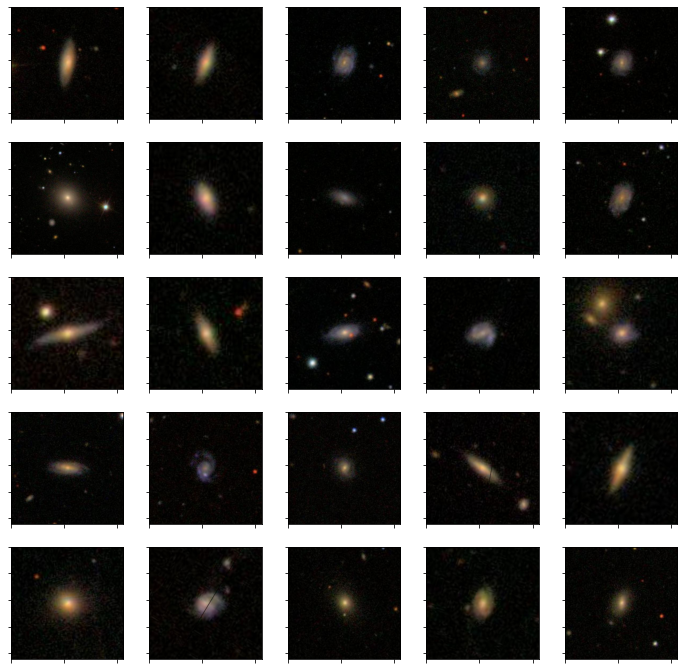

In [7]:
np.random.seed(42)
fig, ax = plt.subplots(5,5, figsize=(12,12), sharex=True)
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(plt.imread(train_images[np.random.randint(0, n_files)]))
        ax[i,j].set_xticklabels("")
        ax[i,j].set_yticklabels("")

In [8]:
labels_tbl = pd.read_csv(DATADIR+'training_classifications.csv')
labels_tbl

GalaxyID  Class1.1  Class1.2  ...  Class11.4  Class11.5  Class11.6
0        100008  0.383147  0.616853  ...   0.000000        0.0   0.325512
1        100023  0.327001  0.663777  ...   0.000000        0.0   0.000000
2        100053  0.765717  0.177352  ...   0.000000        0.0   0.000000
3        100078  0.693377  0.238564  ...   0.000000        0.0   0.000000
4        100090  0.933839  0.000000  ...   0.000000        0.0   0.000000
...         ...       ...       ...  ...        ...        ...        ...
61573    999948  0.510379  0.489621  ...   0.000000        0.0   0.226257
61574    999950  0.901216  0.098784  ...   0.000000        0.0   0.000000
61575    999958  0.202841  0.777376  ...   0.000000        0.0   0.072296
61576    999964  0.091000  0.909000  ...   0.023065        0.0   0.045334
61577    999967  0.767000  0.140000  ...   0.000000        0.0   0.023380

[61578 rows x 38 columns]

In [9]:
label_meanings = ["smooth", "features disk", "star or artifact", "edge-on", "not edge-on",
                  "barred", "not barred", "spiral pattern", "no spiral pattern", 
                  "no bulge", "just noticable bulge", "obvious bulge", "dominant bulge", 
                  "something else odd", "nothing else odd", "completeley rounded", "semi-rounded",
                  "cigar shaped", "ring feature", "lens or arc", "disturbed", "irregular",
                  "other oddness", "merger", "dust lane", "rounded bulge", "boxy bulge", 
                  "no bulge ", "tightly wound spiral", "medium wound spiral", "loosely wound spiral",
                  "one spiral arm", "two spiral arms", "three spiral arms", "four spiral arms",
                  "more than four\nspiral arms", "undetermined number\nof spiral arms"]

In [10]:
def check_directory(directory):
    """
    Checks if a directory at the filepath exists
    and creates it if it does not exist
    
    Arguments
    ----------
    directory : str
        path to the directory
    """
    if not os.path.isdir(directory):
        os.mkdir(directory)

In [11]:
# create dirctory to save plots to
PLOT_DIR = "plots/"
check_directory(PLOT_DIR)

In [12]:
def plot_histograms(tbl_labels, labels_tbl, include_zero=False):
    """
    Makes a grid of all histograms across all labels
    
    Arguments
    ----------
    tbl_labels : lst
        A list of the label names to be shown 
        when producing the histograms
    labels_tbl : pandas.core.frame.DataFrame
        A dataframe containing label information 
        about all sources 
    include_zero : bool
        Option for whether or not to include the 
        default zero entries for a label
    """
    fig, ax = plt.subplots(8, 5, figsize=(18,18))
    index = 1
    nbins = int(np.round(np.log(len(labels_tbl))/np.log(2))) + 1
    for i in trange(8):
        for j in range(5):
            if index < 38:
                col = labels_tbl.iloc[:,index]
                if include_zero:
                    _ = ax[i,j].hist(col, bins=nbins, density=True)
                else:
                    _ = ax[i,j].hist(col, bins=np.linspace(0.00001, 1, num=nbins), density=True)
                ax[i,j].set_title(label_meanings[index-1])
            index += 1
    ax[7,2].axis("off")
    ax[7,3].axis("off")
    ax[7,4].axis("off")
    plt.subplots_adjust(hspace=1)#, wspace=0)
    plt.tight_layout()

100%|██████████| 8/8 [00:00<00:00, 13.48it/s]


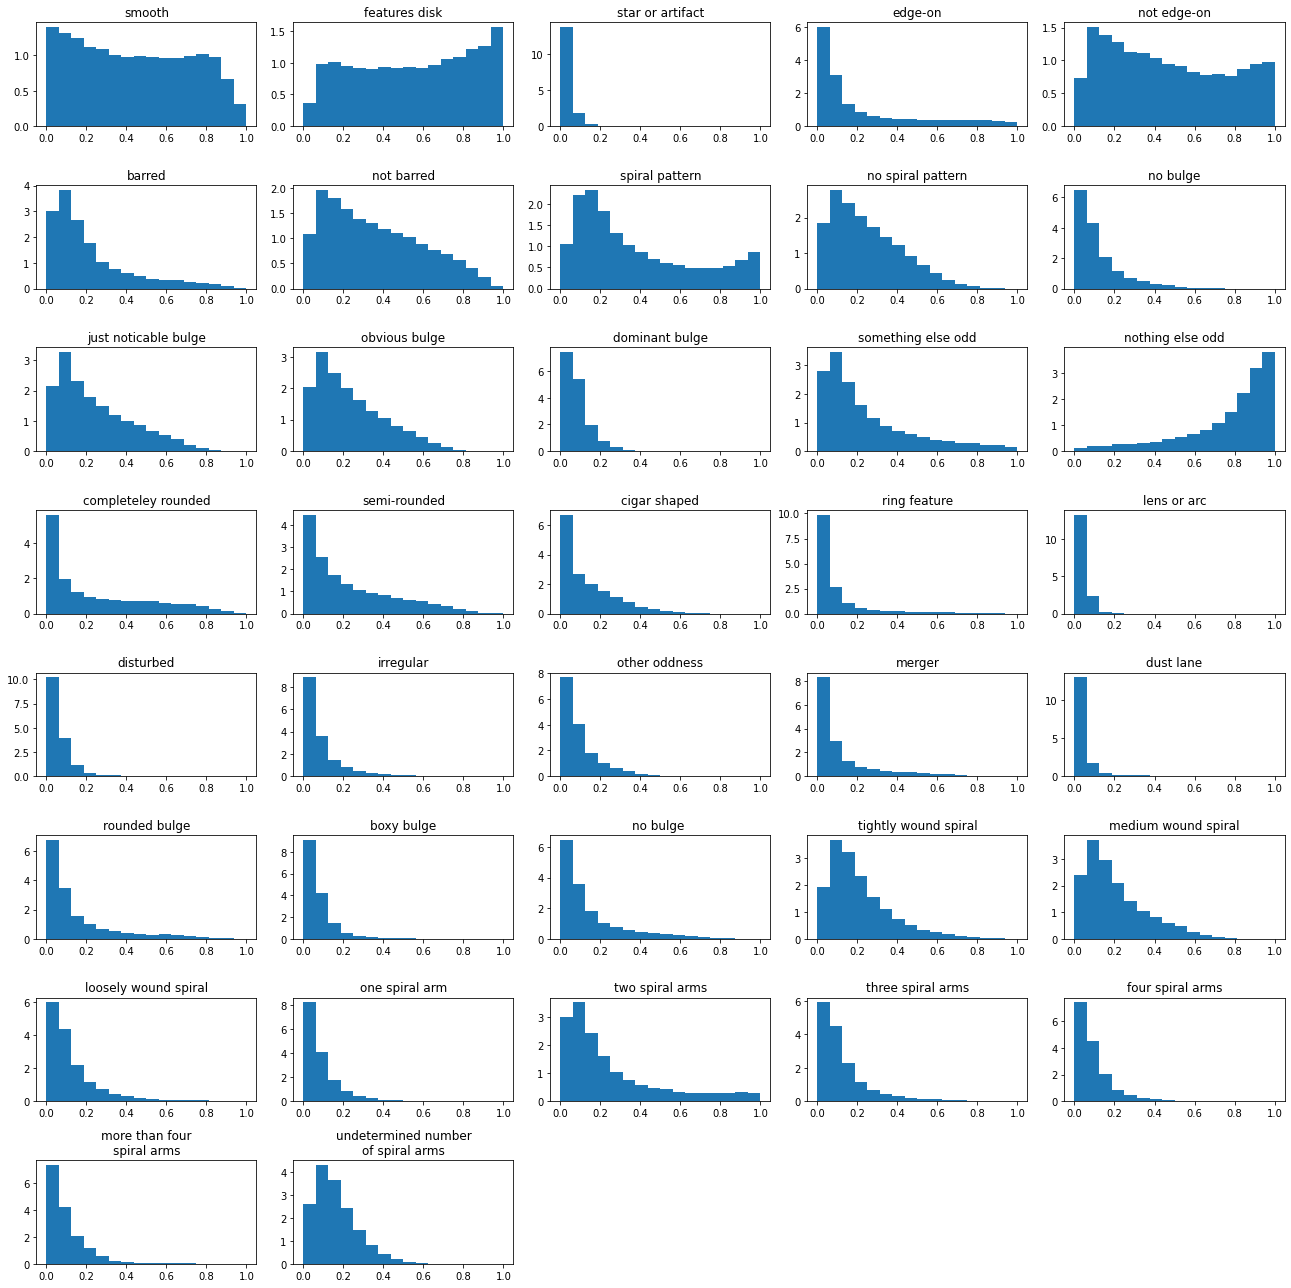

In [13]:
outdir = PLOT_DIR+"histograms/"
check_directory(outdir)

tbl_labels = labels_tbl.columns[1:]
plot_histograms(tbl_labels, labels_tbl)
plt.savefig(outdir+"all_hist.pdf")

Looking at the distributions of the labels, we can see that there is a large amount of skew in the distribution. In general (although there are a few exceptions present), the votes for each label tend to have many votes at the lower end, which falls off as the vote average goes up. The notable exceptions to this trend are the votes for whether the galaxy is smooth or features a disk, which have a realtively flat distribution among all confidences. There is also a multimodal distribution for the "not edge-on" and "spiral pattern" labels, which have upticks at both the low and high end of the spectrum. And finally, there is a noticable anticorrelation between the "something else odd" and "nothing else odd" labels, which can be easily explained as the users were allowed to pick only one of the two options. 

In [14]:
def get_best_img(tbl, label):
    """
    Locates and returns the image with the highest
    vote in the label given
    
    Arguments
    ----------
    tbl : pandas.core.frame.DataFrame
        A dataframe containing label information 
        about all sources
    label : str
        label to search for the best image under
    
    Returns
    ---------
    best_img : numpy.ndarray
        array containing information about the 
        pixels in the image
    galaxy_id : int
        the galaxy id of the returned image
    label_value : float
        the value of the label corresponding to the 
        best image
    """
    best_row = tbl.sort_values(label, ascending=False).iloc[0]
    galaxy_id = int(best_row["GalaxyID"])
    label_value = best_row[label]
    best_name = "%s.jpg"%galaxy_id
    best_path = "training_images/"+best_name
    best_img = plt.imread(best_path)
    return best_img, galaxy_id, label_value

def plot_prototype(tbl, label, meaningful_label, data, outdir):
    best_img, galaxy_id, label_value = get_best_img(tbl, label)
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.set_title("Label: " + meaningful_label + "\nGalaxy: "+str(galaxy_id)+ "\nvalue: " + str(label_value))
    ax.imshow(best_img)
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    outname = "best_"+meaningful_label+".pdf"
    outpath = outdir+"/"+outname
    plt.savefig(outpath)
    plt.show()

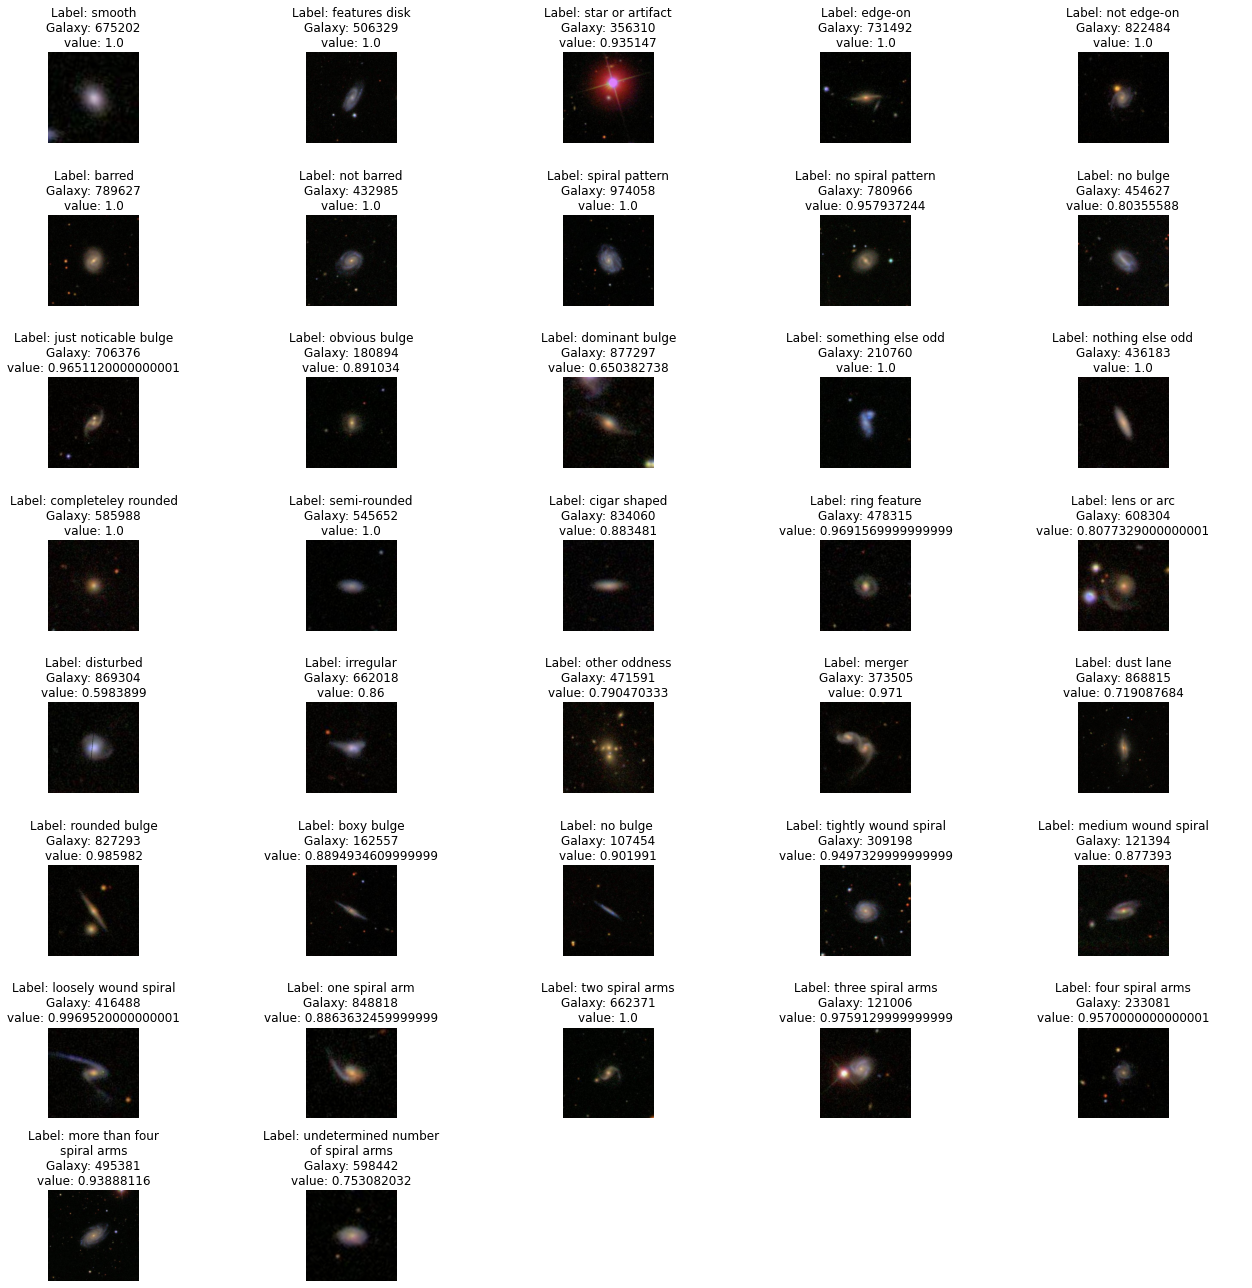

In [15]:
outdir = PLOT_DIR+"best_plots/"
check_directory(outdir)

tbl_labels = labels_tbl.columns[1:]
fig, ax = plt.subplots(8, 5, figsize=(18,18))
index = 0
for i in range(8):
    for j in range(5):
        if index < 37:
            best_img, galaxy_id, label_value = get_best_img(labels_tbl, tbl_labels[index])
            ax[i,j].imshow(best_img)
            ax[i,j].set_xticklabels("")
            ax[i,j].set_yticklabels("")
            ax[i,j].set_title("Label: " + label_meanings[index]+"\nGalaxy: "+str(galaxy_id)+"\nvalue: " + str(label_value))
        ax[i,j].axis('off')
        index += 1
plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.savefig(outdir+"all_types.pdf")

Based on these images, there are some labels that will be easy to identify, such as whether or not there is a star or artifact in the imageas well as the galaxy having no features/being smooth or having some kind of discernable spiral pattern. Some labels that I predict will be harder to discern are the boxy vs rounded bulge, having a lens or arc, or being disturbed in some way other than having a star or artifact. 

## Correlation matrices

This plotting function was based on [this tutorial](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec)

In [16]:
def plot_correlation_matrix(data, height=None, subset=None):
    """
    Generates and plots the correlation matrix of
    the given table of data
    
    Arguments
    ----------
    data : pandas.core.frame.DataFrame
        DataFrame containing information about
        all the sources 
    height : float
        determines the height of the plot.
        Default is None, which will result in 
        the plot being set by matplolib's 
        default plot size
    subset : lst
        a selection of labels for which to create
        the correlation matrix. 
        Default is None. which will result in the 
        matrix being plotted for all the labels 
    """
    if subset is not None:
        data = data[subset]
        
    if height is not None:
        fig, ax = plt.subplots(figsize=(height+5, height))
    else:
        fig, ax = plt.subplots()
    corr = data.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.color_palette("bwr", as_cmap=True),
        square=True)
    sns.diverging_palette(250, 15, s=75, l=40,
                                  n=9, center="dark")
    
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0)
    
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right')

In [17]:
def relabel_tbl(tbl, new_labels):
    no_ids = tbl.drop("GalaxyID", axis=1)
    old_labels = list(no_ids.columns)

    relabel_dict = {old_labels[i]: new_labels[i] for i in range(len(new_labels))}
    relabeled_tbl = no_ids.rename(columns=relabel_dict)
    return relabeled_tbl

In [18]:
relabeled_tbl = relabel_tbl(labels_tbl, label_meanings)

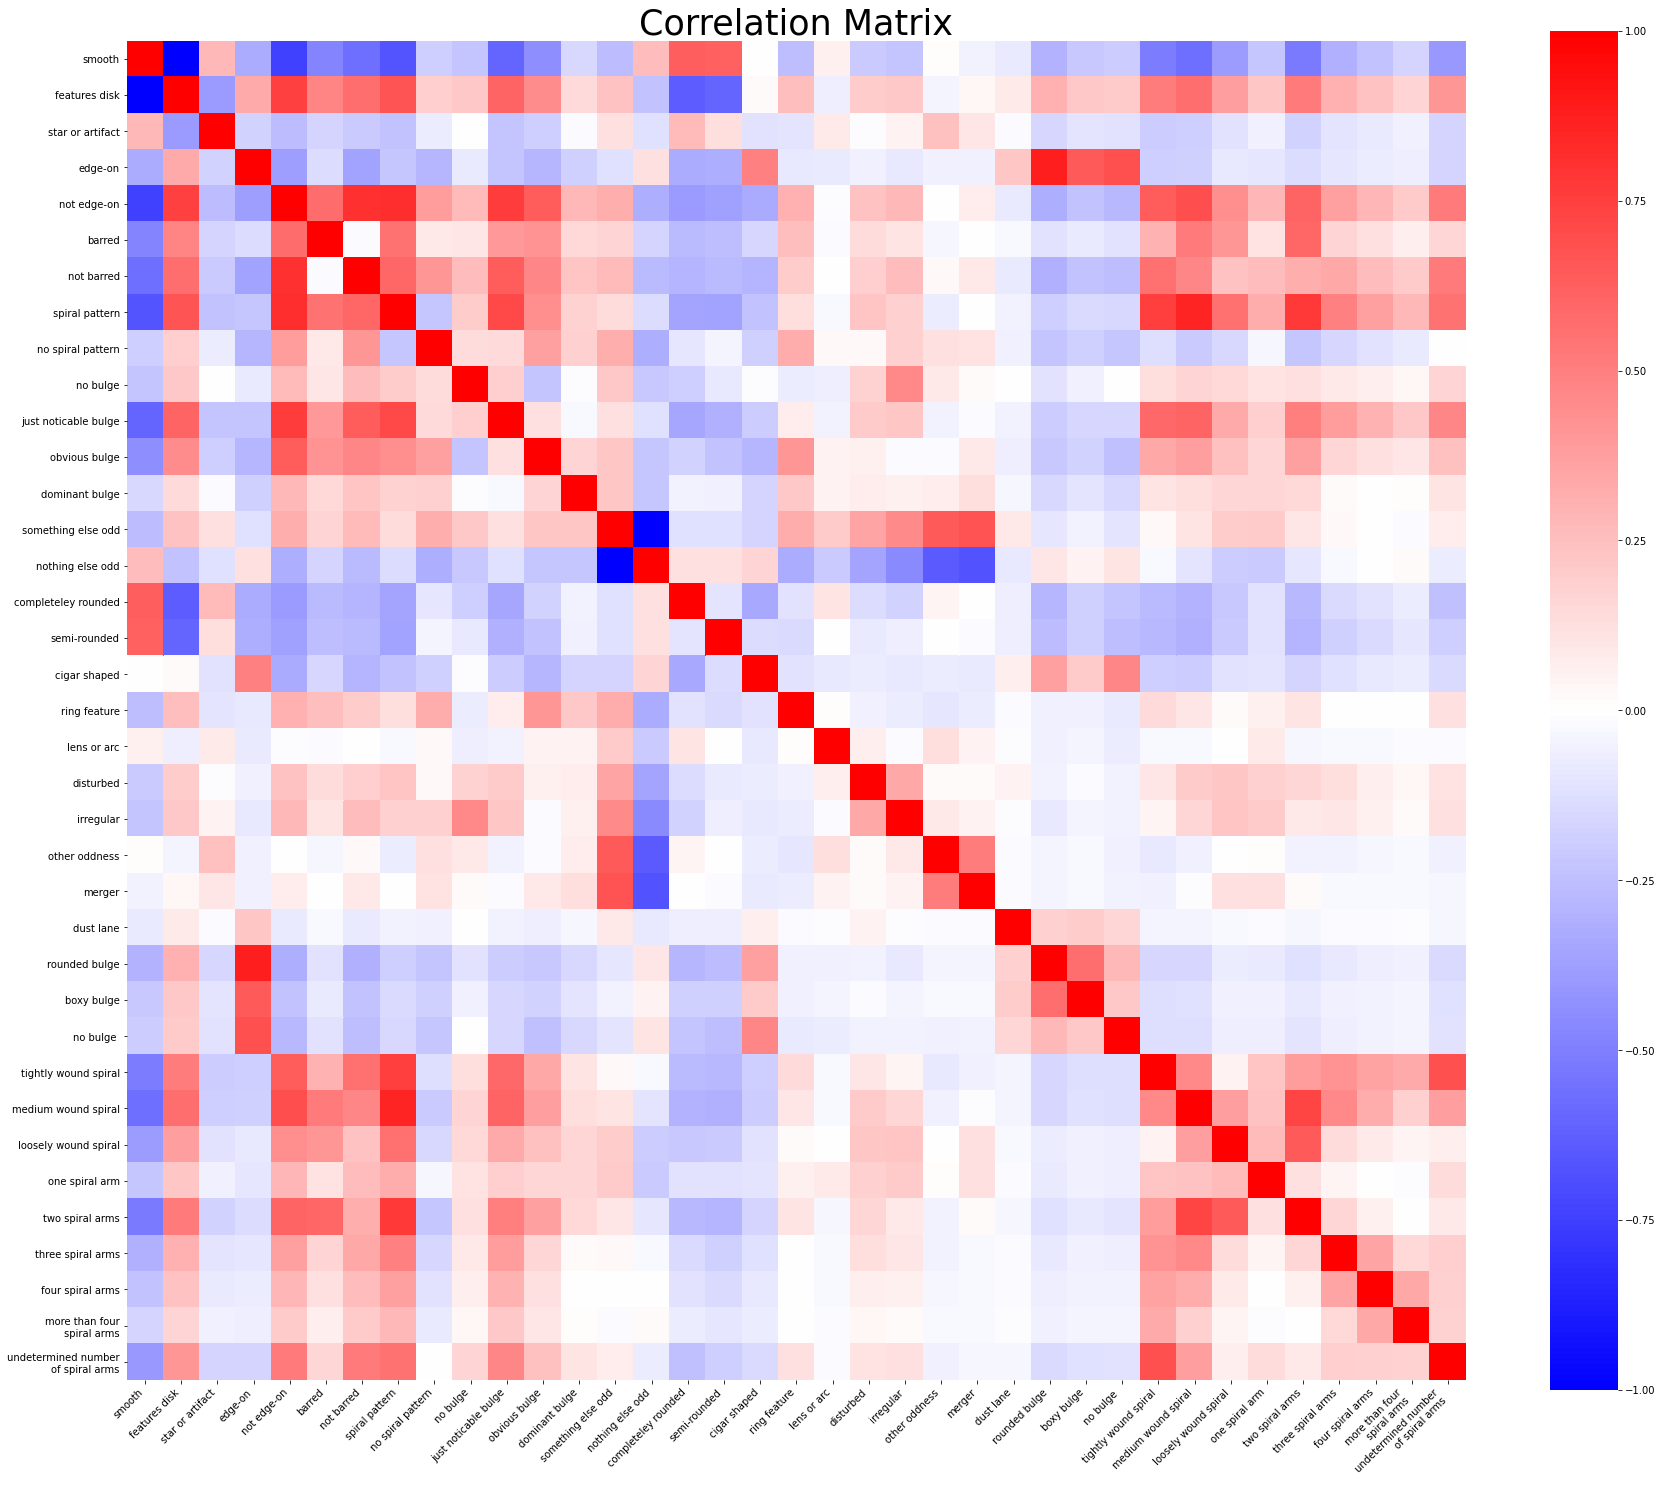

In [19]:
plot_correlation_matrix(relabeled_tbl, 25)
plt.title("Correlation Matrix", fontsize=35);

Looking at the correlation matrix, we can see that there are some combinations of labels that are highly correlated, some that are highly anticorrelated, and some that have little to no correlation. For example, we can see that the labels for being smooth, featuring a disk, or having some star or artifact obscuring the galaxy have a strong anticorrelation. This is to be expected, since these labels correspond to the first question the user is asked, and they are only allowed to pick one before being sent on to the next part. Another set of labels that are highly anticorrelated are the "something else odd" and "nothing else odd" labels; another case where users are only able to pick one of the two. Since we have seen a strong anticorrelation between some of the labels in the same decision class, we will take a closer look at the labels from each class in the decision tree.  

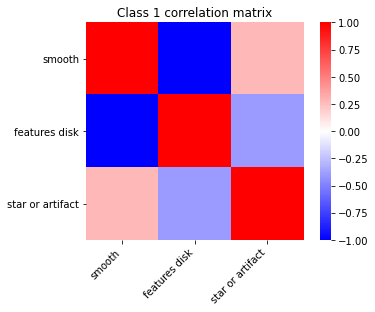

In [20]:
plot_correlation_matrix(relabeled_tbl, subset=label_meanings[0:3])
plt.title("Class 1 correlation matrix");

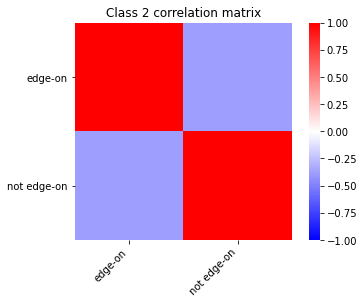

In [21]:
plot_correlation_matrix(relabeled_tbl, subset=label_meanings[3:5])
plt.title("Class 2 correlation matrix");

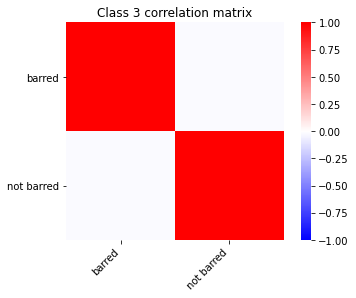

In [22]:
plot_correlation_matrix(relabeled_tbl, subset=label_meanings[5:7])
plt.title("Class 3 correlation matrix");

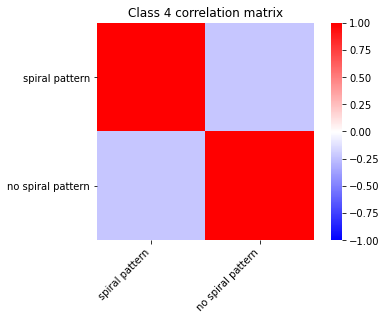

In [23]:
plot_correlation_matrix(relabeled_tbl, subset=label_meanings[7:9])
plt.title("Class 4 correlation matrix");

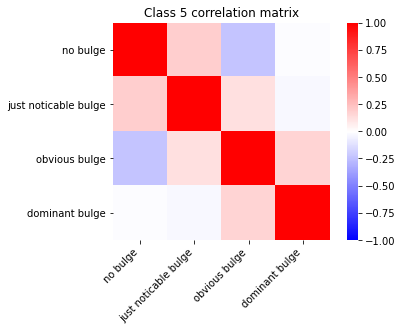

In [24]:
plot_correlation_matrix(relabeled_tbl, subset=label_meanings[9:13])
plt.title("Class 5 correlation matrix");

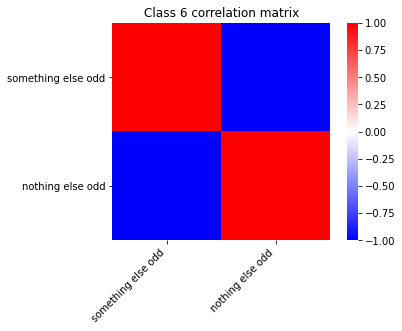

In [25]:
plot_correlation_matrix(relabeled_tbl, subset=label_meanings[13:15])
plt.title("Class 6 correlation matrix");

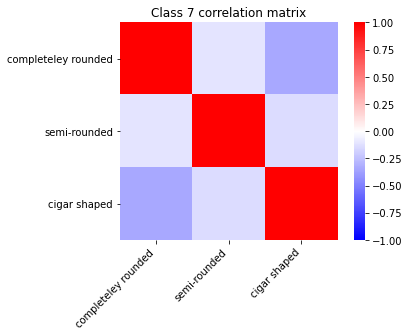

In [26]:
plot_correlation_matrix(relabeled_tbl, subset=label_meanings[15:18])
plt.title("Class 7 correlation matrix");

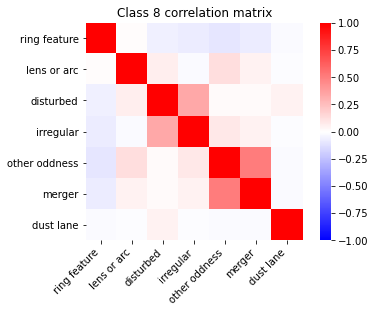

In [27]:
plot_correlation_matrix(relabeled_tbl, subset=label_meanings[18:25])
plt.title("Class 8 correlation matrix");

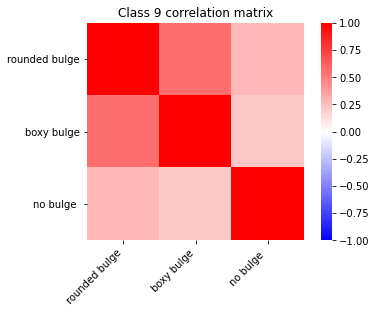

In [28]:
plot_correlation_matrix(relabeled_tbl, subset=label_meanings[25:28])
plt.title("Class 9 correlation matrix");

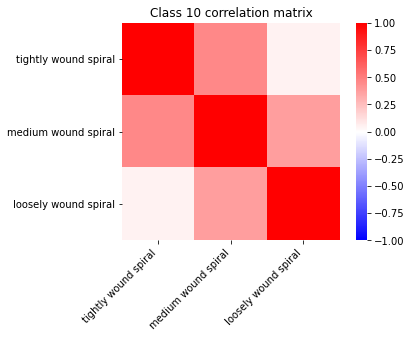

In [29]:
plot_correlation_matrix(relabeled_tbl, subset=label_meanings[28:31])
plt.title("Class 10 correlation matrix");

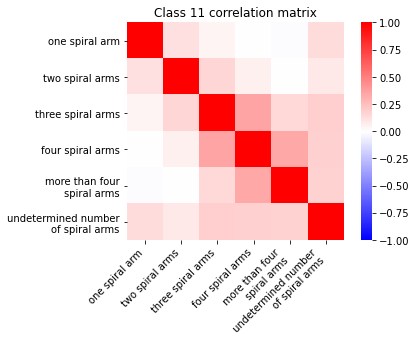

In [30]:
plot_correlation_matrix(relabeled_tbl, subset=label_meanings[31:])
plt.title("Class 11 correlation matrix");

## Downsizing images

In order to train a model to classify the galaxy images, we will need to repeatedly compare predictions for each image in the training set to its known labels. If were were to read in all the images at once, it would require a minimum memory of $n_{imgs} \times <size_{img}>$. For a training set of 61,578 images, with an average size of around 15KB, it would require a minimum of 923MB, nearly 1GB just to read in the images. We will need to come up with a way to reduce the amount of memory needed to train the model. 

Some ways that this can be done is by downsizing the images so that they are smaller, or by reading in the data in batches and working with smaller subsets of the data at a time. 

In [31]:
test_image = "training_images/100157.jpg"

In [32]:
def before_and_after(img_path, reducing_method):
    old_image = plt.imread(img_path)
    new_image = reducing_method(img_path)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title("before")
    ax1.imshow(old_image)
    
    ax2.set_title("after")
    ax2.imshow(new_image)

In [33]:
def hard_cut(img_path):
    """chops off 173 pixels from each 
    edge of the image"""
    the_image = plt.imread(img_path)
    return the_image[173:251, 173:251]

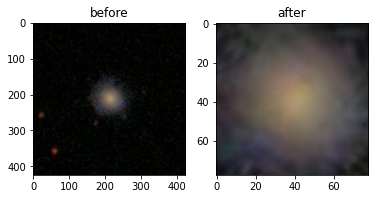

In [34]:
before_and_after(test_image, hard_cut)

In [35]:
def soft_cut(img_path):
    the_image = plt.imread(img_path)
    return the_image[100:324, 100:324]

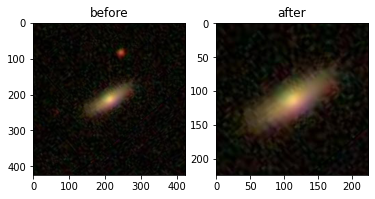

In [36]:
test_image = train_images[np.random.randint(0, n_files)]
before_and_after(test_image, soft_cut)

My method for reducing the size of the images by a factor of ~30 is as follows. The images start out with a shape of 424x424 pixels. To achieve a size reduction of order 30, we will need to reduce the images so that they are roughly 77x77 pixels. In other words, we need to remove 347 pixels from each row of the image. We will first start by uniformly decreasing the borders of the image by 100 from each side. A size of 100 was chosen because the first 100 pixels on each edge is mostly black space and contains no imformation about the galaxy at the center. This will result in a smaller image with shape 224x224. Next we will resample the pixels to form a lower resolution image. We will keep every third pixel and discard the rest, this will reduce our image to have a shape of 75x75. The reduction in image size is a factor of $\frac{424^2}{75^2} = 32$. 

In [37]:
def cut_and_shred(img_path):
    the_image = soft_cut(img_path)
    keep = np.arange(0, len(the_image), 3)
    first_index = the_image[keep]
    second_index = first_index[:, keep]
    return second_index

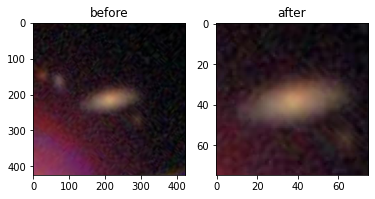

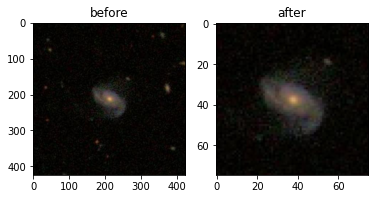

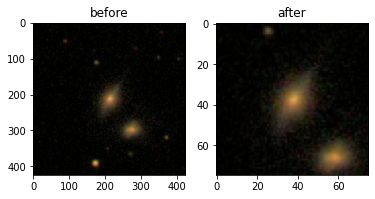

In [38]:
for i in range(3):
    test_image = train_images[np.random.randint(0, n_files)]
    before_and_after(test_image, cut_and_shred)

In [39]:
def reduce_and_save(file_path, reduction_method, outdir):
    file_name = os.path.basename(file_path)
    reduced_image = reduction_method(file_path)
    plt.imsave(outdir+file_name, reduced_image)

In [40]:
outdir = "reduced_training_images/"
check_directory(outdir)
reduced_images = glob.glob("reduced_training_images/*.jpg")
if len(reduced_images) != len(train_images):
    for i in trange(len(train_images)):
        reduce_and_save(train_images[i], cut_and_shred, outdir)

## Defining a generator function

In [41]:
class MyGen:
    def __init__(self, path, tbl, start_index=0, batch_size=128, outtype="array"):
        self.path = path
        self.tbl = tbl
        self.index = start_index-1
        self.length = len(tbl)
        self.batch_size = batch_size
        self.outtype = outtype
        
    def __iter__(self):
        return self
    
    def __next__(self):
        # set the output shapes
        images = np.zeros((self.batch_size, 75, 75, 3))
        labels = np.zeros((self.batch_size, 37))
        for i in range(self.batch_size):
            self.index += 1
            if self.index >= self.length:
                # reset the index
                self.index = 0# raise StopIteration
                # rehuffle the table to randomize images
                self.tbl = self.tbl.sample(frac=1)
            source = self.tbl.iloc[self.index]
            images[i] = plt.imread(self.path+str(int(source["GalaxyID"]))+".jpg", format="jpg")/255.0
            labels[i] = np.asarray(source.drop("GalaxyID"))
        if self.outtype == "tensor":
            return (K.constant(images), K.constant(labels))
        return (images, labels)

In [42]:
DATADIR

'/content/drive/MyDrive/astro_128/'

In [43]:
# temp = glob.glob(DATADIR+"reduced_training_images/*.jpg")
# len(temp)

In [44]:
n_source = 50
n_iter = 10
temp=MyGen("reduced_training_images/", labels_tbl, batch_size=n_source, outtype="tensor")

start_time = time.time()
for i in range(n_iter):
    next(temp)
print("It takes %s seconds per image"%((time.time() - start_time)/(n_source*n_iter)))

It takes 0.011096983432769776 seconds per image


## Splitting the data into train and validation sets

In [45]:
train, validation = train_test_split(labels_tbl, test_size=0.2, shuffle=True, random_state=42)

Now that we have split the data into the train and validation sets, we will compare the distributions of the labels to make sure that they both have distributions that are similar to the distribution of the whole data set, as seen above.

100%|██████████| 8/8 [00:00<00:00, 18.27it/s]


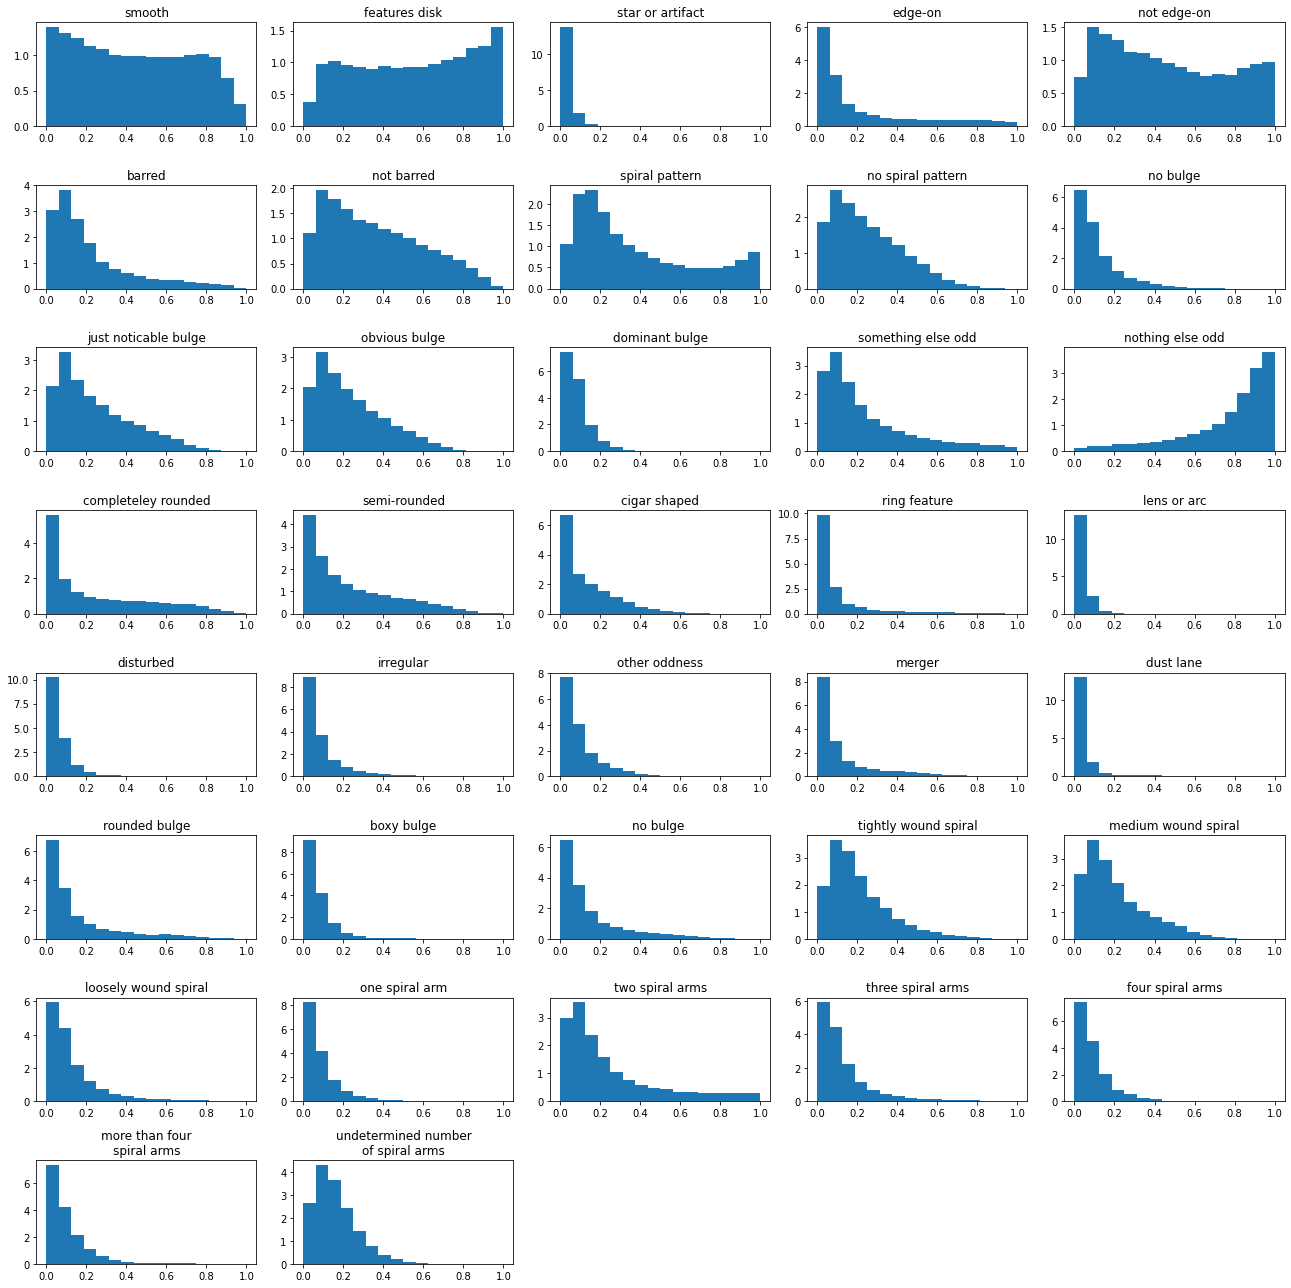

In [46]:
plot_histograms(tbl_labels, train)
plt.savefig("plots/histograms/train_hist.pdf")

100%|██████████| 8/8 [00:00<00:00, 23.95it/s]


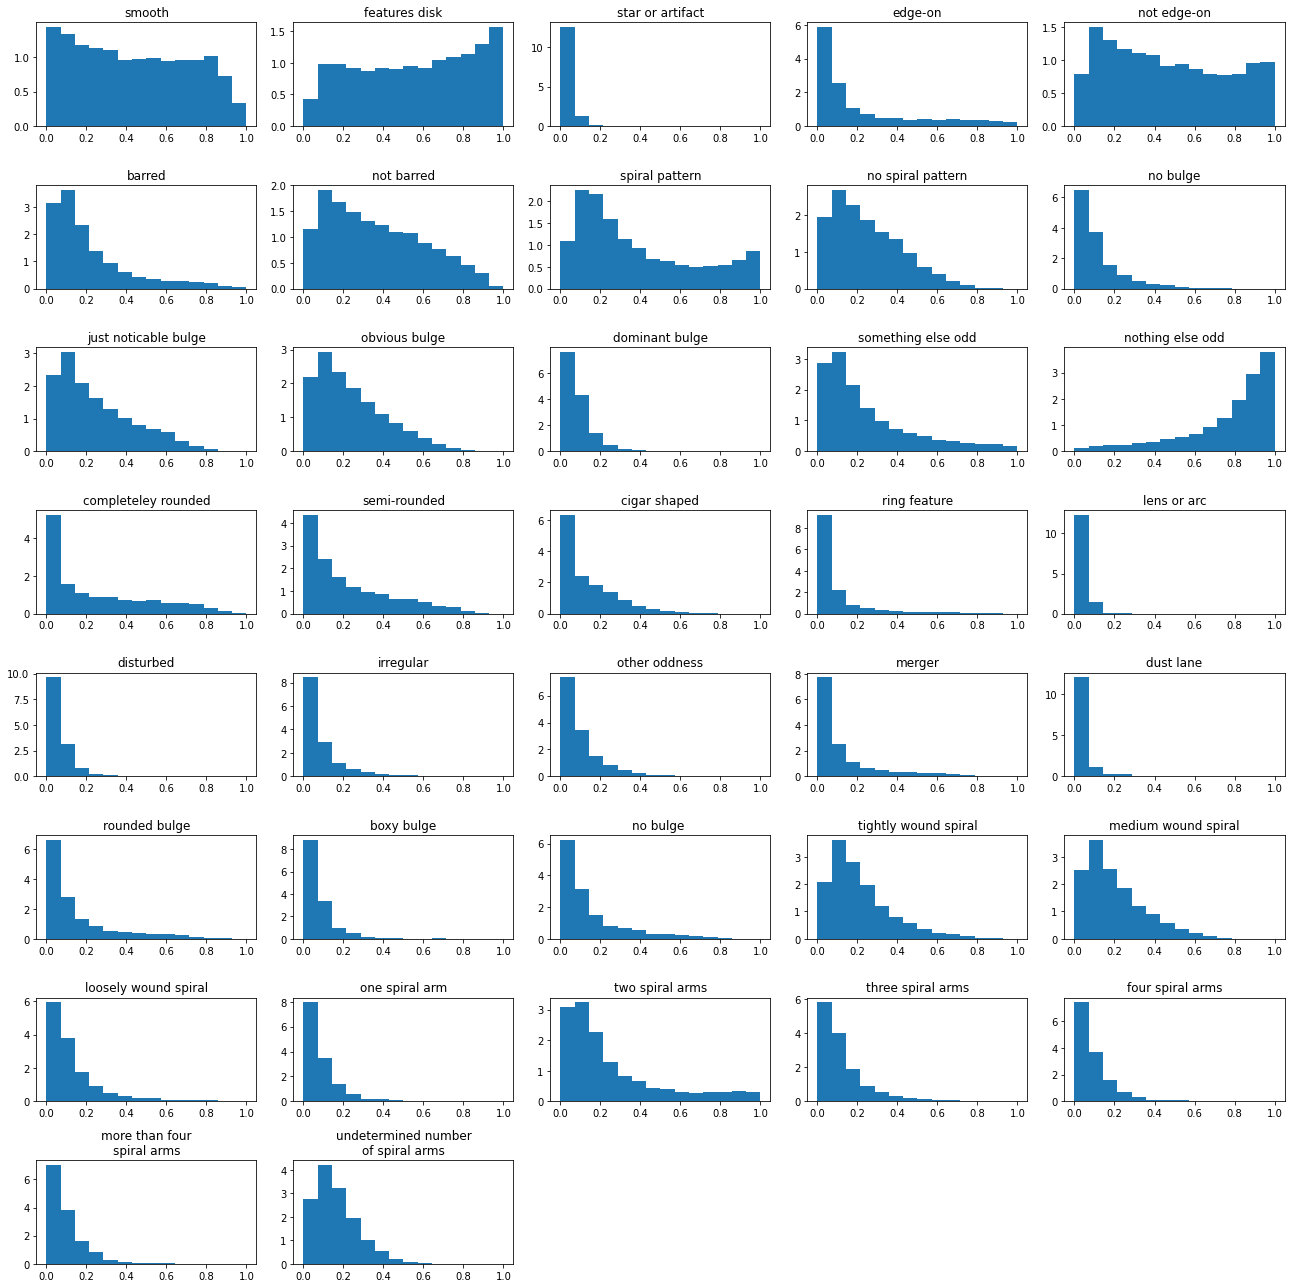

In [47]:
plot_histograms(tbl_labels, validation)
plt.savefig("plots/histograms/validation_hist.pdf")

After comparing these histograms to each other and to the histogram of all sources, it appears that there are no systematic differences bewteen them, so I will use this train/test split to move forward and train my neural network with. 

Before training the neural network, I will try a very simple classification that is a guess that the label for each image is the average value of the label in the training set. We will do this without looking at the images at all. Since this is a very simple model that does not take into consideration any detail from the images themselves, the neural network that we will train must perform better. 

In [48]:
relabeled_training = relabel_tbl(train, label_meanings)
relabeled_validation=relabel_tbl(validation, label_meanings)

In [49]:
def loss_RMSE(train, test):
    label_contents = np.asarray(test)
    label_averages = np.mean(np.asarray(train), axis=0)
    difference_squared = (label_contents - label_averages)**2
    sum_of_squares = np.sum(difference_squared)
    loss_rmse = np.sqrt((label_contents.shape[0]*label_contents.shape[1])**-1 * sum_of_squares)
    return loss_rmse

In [50]:
print("The RMSE loss of the training set is:  ", loss_RMSE(relabeled_training, relabeled_training))
print("The RMSE loss of the validation set is:", loss_RMSE(relabeled_training, relabeled_validation))

The RMSE loss of the training set is:   0.16379325488087598
The RMSE loss of the validation set is: 0.16409999337431225


## Building the Convolutional Neural Network

In [51]:
generate_model_data = False

if generate_model_data:
    N_train = len(train)
    N_validate =len(validation)

    # # generate images
    # x_train = np.zeros((N_train, 75, 75, 3))
    # y_train = np.zeros((N_train, 37))

    # x_test = np.zeros((N_validate, 75, 75, 3))
    # y_test = np.zeros((N_validate, 37))

    TrainGenerator = MyGen("reduced_training_images/", train, batch_size=N_train, outtype="tensor")
    TestGenerator = MyGen("reduced_training_images/", validation, batch_size=N_validate, outtype="tensor")

    # for i in range(N_train):
    #     x_train[i], y_train[i] = next(TrainGenerator)

    # for i in range(N_validate):
    #     x_test[i], y_test[i] = next(TestGenerator)

    X_train, Y_train = next(TrainGenerator)
    X_test, Y_test = next(TestGenerator)

    input_shape = X_train[0].shape
    print(input_shape)

In [52]:
setup_model = False

if setup_model:
    with tf.device('/gpu:0'):
        model = Sequential()

        model.add(Conv2D(32, (3,3), input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=0.1))

        model.add(Conv2D(64, (3,3), input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=0.1))

        model.add(Conv2D(128, (3,3), input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=0.1))

        model.add(Flatten())

        model.add(Dense(128, activation="relu"))
        model.add(Dropout(rate=0.1))

        model.add(Dense(32, activation="relu"))

        model.add(Dense(37))
        model.add(Activation("sigmoid"))

        model.compile(optimizer="adam",
                      loss="mse", 
                      metrics=["mse"])

In [53]:
run_training = False

if run_training:
    run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

    #define path to save model
    model_path = f"nn_results/datalab_nn_{run_time_string}.h5"
    print(f"Training ... {model_path}")

    logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mse", factor=0.75,
                                                     patience=3, min_lr=1e-6, verbose=1, cooldown=0)

    csv_logger = tf.keras.callbacks.CSVLogger(f"nn_results/training_{run_time_string}.log")

    earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_mse", min_delta=0.00001,
                                                 patience=5, verbose=1, mode="auto")

    model_check = tf.keras.callbacks.ModelCheckpoint(model_path, 
                                                     monitor="val_mse", 
                                                     save_best_only=True,
                                                     verbose=1)

    history = model.fit(x=X_train, y=Y_train, 
                         epochs=20, 
                         batch_size=128,
                         validation_data=(X_test, Y_test),
                         callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

In [54]:
latest_log_file = "/content/drive/MyDrive/astro_128/problem_15/training_2021-05-01T07_17.log"
hist_df = pd.read_csv(latest_log_file)
hist_df

epoch  accuracy  ...  val_loss   val_mse
0       0  0.524935  ...  0.094677  0.094677
1       1  0.596563  ...  0.038785  0.038785
2       2  0.630283  ...  0.020507  0.020507
3       3  0.647102  ...  0.014899  0.014899
4       4  0.668333  ...  0.013183  0.013183
5       5  0.704542  ...  0.012314  0.012314
6       6  0.719782  ...  0.012071  0.012071
7       7  0.733140  ...  0.012347  0.012347
8       8  0.742997  ...  0.011060  0.011060
9       9  0.746134  ...  0.011229  0.011229
10     10  0.755546  ...  0.010726  0.010726
11     11  0.757610  ...  0.010590  0.010590
12     12  0.760767  ...  0.010890  0.010890
13     13  0.765301  ...  0.010649  0.010649
14     14  0.767487  ...  0.010266  0.010266
15     15  0.769976  ...  0.010507  0.010507
16     16  0.771110  ...  0.010476  0.010476
17     17  0.773498  ...  0.010236  0.010236
18     18  0.775198  ...  0.010010  0.010010
19     19  0.777263  ...  0.010006  0.010006

[20 rows x 10 columns]

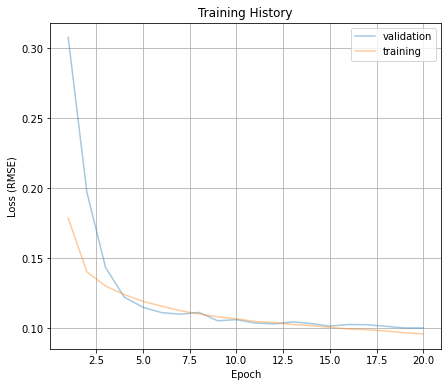

In [55]:
plt.figure(figsize=(7,6))
plt.title("Training History")
plt.plot(hist_df.index + 1, np.sqrt(hist_df["val_mse"]) ,alpha=0.4, label="validation")
plt.plot(hist_df.index + 1, np.sqrt(hist_df["mse"]) ,alpha=0.4, label="training")

plt.xlabel("Epoch")
plt.ylabel("Loss (RMSE)")
plt.legend()
plt.grid()

#plt.savefig("plots/cnn_loss/correct_loss.pdf")
#plt.savefig("plots/cnn_loss/correct_loss.png")

In [56]:
# model.save("CNN_training.h5", overwrite=False)

My convolutional neural network accepts images with a shape of (75, 75, 3): the image is 75x75 pixels and has three color channels. These images are then passed into three 2D convolution layers. The first convolution layer passes 32 kernels with a size of 3x3 and a relu activation. It is then passed into a max pooling layer with a pool size of 2x2. This layer is then followed by a dropout layer of 10%. The second convolution layer passes 64 kernels of size 3x3 and has an relu activation function. It is then passed into a max pooling layer with a pool size of 2x2, and followed by a dropout layer of 10\%. The third and final convolution layer passes 128 kernels of size 3x3 and has a relu activation function. It is then passed into a max pooling layer of 2x2 and followed by a dropout layer of 10%. After then convolution layers, the data is passed through a flatten layer before being passed into the dense layers. There are two dense layers, both with relu activation functions. The first dense layer has 128 connecitons and is followed by a 10% dropout layer. The second dense layer has 32 connections and has no dropout layer. The final layer is a dense layer and has a sigmoid activation function to force the outputs to be between 0 and 1.  

### Now I will try passing the image generator into the CNN 

In [57]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [58]:
setup_model = True

if setup_model:
    input_shape = (75, 75, 3)

    with tf.device('/gpu:0'):
        model = Sequential()

        model.add(Conv2D(32, (3,3), input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=0.1))

        model.add(Conv2D(64, (3,3), input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=0.1))

        model.add(Conv2D(128, (3,3), input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=0.1))

        model.add(Flatten())

        model.add(Dense(128, activation="relu"))
        model.add(Dropout(rate=0.1))

        model.add(Dense(32, activation="relu"))

        model.add(Dense(37))
        model.add(Activation("sigmoid"))

        model.compile(optimizer="adam",
                      loss="mse", 
                      metrics=["mse", "categorical_crossentropy", "accuracy"])
        
        model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 73, 73, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 34, 34, 64)        0

In [59]:
train_this_model = False

if train_this_model:
    train_batch = 256
    test_batch = int(train_batch/4)

    train_steps_epoch = int(np.ceil(len(train)/train_batch))
    test_steps_epoch = int(np.ceil(len(validation)/test_batch))
    
    train_generator = MyGen("reduced_training_images/", train, batch_size=256, outtype="tensor")
    test_generator = MyGen("reduced_training_images/", validation, batch_size=128, outtype="tensor")
    
    run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

    #define path to save model
    model_path = f"nn_results/datalab_nn_{run_time_string}.h5"
    print(f"Training ... {model_path}")

    logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mse", factor=0.75,
                                                     patience=3, min_lr=1e-6, verbose=1, cooldown=0)

    csv_logger = tf.keras.callbacks.CSVLogger(f"nn_results/training_{run_time_string}.log")

    earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_mse", min_delta=0.00001,
                                                 patience=5, verbose=1, mode="auto")

    model_check = tf.keras.callbacks.ModelCheckpoint(model_path, 
                                                     monitor="val_mse", 
                                                     save_best_only=True,
                                                     verbose=1)

    history_gen = model.fit(train_generator, 
                                  steps_per_epoch=train_steps_epoch, 
                                  epochs=20,
                                  validation_data=test_generator,
                                  validation_steps=test_steps_epoch,
                                  callbacks=[tensorboard_callback, reduce_lr, csv_logger, model_check, earlystop])

In [60]:
latest_log_file = "/content/drive/MyDrive/astro_128/problem_15/training_2021-05-01T07_17.log"
hist_df = pd.read_csv(latest_log_file)
hist_df

epoch  accuracy  ...  val_loss   val_mse
0       0  0.524935  ...  0.094677  0.094677
1       1  0.596563  ...  0.038785  0.038785
2       2  0.630283  ...  0.020507  0.020507
3       3  0.647102  ...  0.014899  0.014899
4       4  0.668333  ...  0.013183  0.013183
5       5  0.704542  ...  0.012314  0.012314
6       6  0.719782  ...  0.012071  0.012071
7       7  0.733140  ...  0.012347  0.012347
8       8  0.742997  ...  0.011060  0.011060
9       9  0.746134  ...  0.011229  0.011229
10     10  0.755546  ...  0.010726  0.010726
11     11  0.757610  ...  0.010590  0.010590
12     12  0.760767  ...  0.010890  0.010890
13     13  0.765301  ...  0.010649  0.010649
14     14  0.767487  ...  0.010266  0.010266
15     15  0.769976  ...  0.010507  0.010507
16     16  0.771110  ...  0.010476  0.010476
17     17  0.773498  ...  0.010236  0.010236
18     18  0.775198  ...  0.010010  0.010010
19     19  0.777263  ...  0.010006  0.010006

[20 rows x 10 columns]

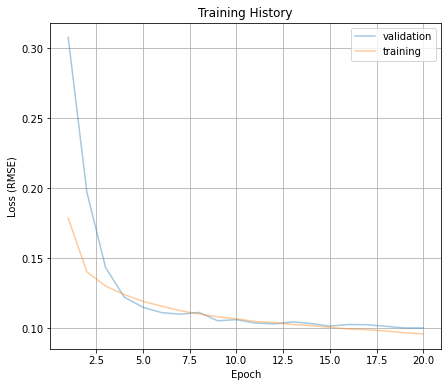

In [61]:
plt.figure(figsize=(7,6))
plt.title("Training History")
plt.plot(hist_df.index + 1, np.sqrt(hist_df["val_mse"]) ,alpha=0.4, label="validation")
plt.plot(hist_df.index + 1, np.sqrt(hist_df["mse"]) ,alpha=0.4, label="training")

plt.xlabel("Epoch")
plt.ylabel("Loss (RMSE)")
plt.legend()
plt.grid();

In [62]:
#model.save("problem_15_generator_trained_CNN.h5", overwrite=False)
#model.save("CNN_training.h5", overwrite=False)

In [63]:
len(train)*75*75, len(validation)*75*75

(277098750, 69277500)

My neural network has a total of 901,605 trainable parameters. This seems rather high, since the total number of pixels in a single image is $75^2 = 5625$, which is 160 times smaller than the number of trainable parameters. However when we look at the total number of pixels in the compressed training set, I can see that there are a total of 277,098,750 pixels being passed in to train on, and 69,277,500 pixels being passed in to use for validation. 

An alternate network architecture is using a ResNet, which has already been proven to work well for image classification. One might think that adding more layers to their neural net would increase its performance, but this turns out to not be the case. ResNets improve on the performance of a deep neural net by sending information from one layer to a deeper one. In this way, they are able to allow a much deeper network with "shortcut" paths to deeper layers to perform better than an equally deep network without the shortcuts. 

## Implementing a ResNet

In [64]:
build_res_net = True

if build_res_net:
    with tf.device('/gpu:0'):
        res_model = Sequential()

        res_model.add(tf.keras.applications.ResNet50(
            include_top=False,
            weights=None,
            input_tensor=tf.keras.layers.Input(shape=(75, 75,3)),
            input_shape=(75, 75, 3),
            pooling="max")
        )
        res_model.add(Dense(37, activation='sigmoid'))

        res_model.compile(optimizer="adam",
                  loss="mse", 
                  metrics=["mse", "categorical_crossentropy", "accuracy"])

        res_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 37)                75813     
Total params: 23,663,525
Trainable params: 23,610,405
Non-trainable params: 53,120
_________________________________________________________________


In [65]:
train_res_net = False

if train_res_net:
    train_batch = 256
    test_batch = int(train_batch/4)

    train_steps_epoch = int(np.ceil(len(train)/train_batch))
    test_steps_epoch = int(np.ceil(len(validation)/test_batch))


    train_generator = MyGen("reduced_training_images/", train, batch_size=train_batch, outtype="tensor")
    test_generator = MyGen("reduced_training_images/", validation, batch_size=test_batch, outtype="tensor")


    train_this_model = True

    if train_this_model:
        run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

        #define path to save model
        model_path = f"nn_results/datalab_nn_{run_time_string}.h5"
        print(f"Training ... {model_path}")

        logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mse", factor=0.75,
                                                        patience=3, min_lr=1e-6, verbose=1, cooldown=0)

        csv_logger = tf.keras.callbacks.CSVLogger(f"nn_results/training_{run_time_string}.log")

        earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_mse", min_delta=0.00001,
                                                    patience=5, verbose=1, mode="auto")

        model_check = tf.keras.callbacks.ModelCheckpoint(model_path, 
                                                        monitor="val_mse", 
                                                        save_best_only=True,
                                                        verbose=1)

        history_gen = res_model.fit(train_generator, 
                                      steps_per_epoch=train_steps_epoch, 
                                      epochs=20,
                                      validation_data=test_generator,
                                      validation_steps=test_steps_epoch,
                                      callbacks=[tensorboard_callback, csv_logger, model_check, earlystop, reduce_lr,])

In [66]:
# res_model.save("res_net_train_no_scheduler.h5", overwrite=False)

In [67]:
latest_log_file = "/content/drive/MyDrive/astro_128/problem_18/training_2021-05-01T21_58.log"
hist_df = pd.read_csv(latest_log_file)
hist_df

epoch  accuracy  ...  val_loss   val_mse
0      0  0.613686  ...  0.036596  0.036596
1      1  0.671167  ...  0.060783  0.060783
2      2  0.705938  ...  0.043135  0.043135
3      3  0.736601  ...  0.012248  0.012248
4      4  0.754473  ...  0.023972  0.023972
5      5  0.759998  ...  0.028779  0.028779
6      6  0.768013  ...  0.015919  0.015919
7      7  0.768722  ...  0.015361  0.015361
8      8  0.772567  ...  0.036098  0.036098

[9 rows x 9 columns]

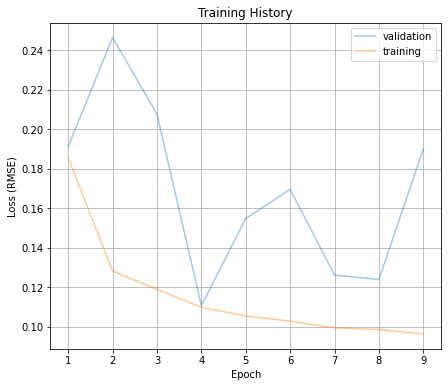

In [68]:
plt.figure(figsize=(7,6))
plt.title("Training History")
plt.plot(hist_df.index + 1, np.sqrt(hist_df["val_mse"]) ,alpha=0.4, label="validation")
plt.plot(hist_df.index + 1, np.sqrt(hist_df["mse"]) ,alpha=0.4, label="training")

plt.xlabel("Epoch")
plt.ylabel("Loss (RMSE)")
plt.legend()
plt.grid()
#plt.savefig("gen_loss.pdf")
#plt.savefig("gen_loss.png")

## Image Augmentation

Since we are working with a finite set of images to train our model on, we run the risk of our model memorizing the training and validation images, and not performing well on new images. To avoid this, and to make sure that our model will be able to recognize similar galaxies that are just tilted at a different orientation, we will introduce an image augmentor, which will rotate and flip the images in the training and validation sets so the neural net has "more" data to train with. In this manner, we can make sure that the neural net will never see the same image twice, despite the fact that the objects themselves will be the same.

In [69]:
def chop_edges(the_image):
    return the_image[100:324, 100:324]

def augment_image(img_path):
    """rotates and flips image before reducing it in size"""
    image = plt.imread(img_path)
    image = imutils.rotate(image, angle=random.randint(0,360))
    # mirror across x
    if random.randint(0,1) == 1:
        image = image[:, ::-1, :]
    # mirror across y
    if random.randint(0,1) == 0:
        image = image[::-1, :, :]
    # reduce size
    the_image = chop_edges(image) 
    keep = np.arange(0, len(the_image), 3)
    first_index = the_image[keep]
    second_index = first_index[:, keep]
    return second_index

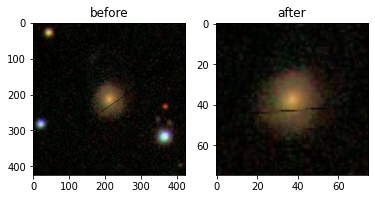

In [70]:
before_and_after(train_images[random.randint(0, n_files)], augment_image)

In [71]:
class ImgAugment:
    def __init__(self, path, tbl, start_index=0, batch_size=128, outtype="array"):
        self.path = path
        self.tbl = tbl
        self.index = start_index-1
        self.length = len(tbl)
        self.batch_size = batch_size
        self.outtype = outtype
            
    def __iter__(self):
        return self
    
    def __next__(self):
        # set the output shapes
        images = np.zeros((self.batch_size, 75, 75, 3))
        labels = np.zeros((self.batch_size, 37))
        for i in range(self.batch_size):
            self.index += 1
            if self.index >= self.length:
                # reset the index
                self.index = 0# raise StopIteration
                # rehuffle the table to randomize images
                self.tbl = self.tbl.sample(frac=1)
            source = self.tbl.iloc[self.index]
            # change the images method
            images[i] = augment_image(self.path+str(int(source["GalaxyID"]))+".jpg")/255.0
            # leave the labels method unchanged
            labels[i] = np.asarray(source.drop("GalaxyID"))
        if self.outtype == "tensor":
            return (K.constant(images), K.constant(labels))
        return (images, labels)

In [72]:
temp = ImgAugment("training_images/", labels_tbl, batch_size=1)

In [73]:
n_source = 128
n_iter = 16
temp=ImgAugment("training_images/", labels_tbl, batch_size=n_source, outtype="tensor")

start_time = time.time()
for i in range(n_iter):
    next(temp)
print("It takes %s seconds per image"%((time.time() - start_time)/(n_source*n_iter)))

It takes 0.004873733036220074 seconds per image


# Reweighting

I was ultimately able to figure out how to turn my list elements into a tensor based on [this](https://stackoverflow.com/questions/37697747/typeerror-tensor-object-does-not-support-item-assignment-in-tensorflow) stack overflow post. 

In [74]:
def reweight_labels(NN_labels):
    rw = [0]*37
    # multi-path labels will be done later

    # reweighting probabilities:
    #class 1 stays as it is
    rw[0] = NN_labels[:,0] 
    rw[1] = NN_labels[:,1]
    rw[2] = NN_labels[:,2]

    #class 2 gets reweighted
    rw[3] = rw[2]*NN_labels[:,3] # class 2.1
    rw[4] = rw[2]*NN_labels[:,4] # class 2.2

    # class 3 gets reweighted
    rw[5] = rw[4]*NN_labels[:,5] # class 3.1
    rw[6] = rw[4]*NN_labels[:,6] # class 3.2

    # class 4 gets reweighted
    rw[7] = rw[4]*NN_labels[:,7] # class 4.1
    rw[8] = rw[4]*NN_labels[:,8] # class 4.2

    # class 5 gets reweighted
    rw[9] = rw[4]*NN_labels[:,9] # class 5.1
    rw[10]= rw[4]*NN_labels[:,10]# class 5.2
    rw[11]= rw[4]*NN_labels[:,11]# class 5.3
    rw[12]= rw[4]*NN_labels[:,12]# class 5.4

    # class 6 gets reweighted
    rw[13] = (rw[0] + rw[1])*NN_labels[:,13] # class 6.1
    rw[14] = (rw[0] + rw[1])*NN_labels[:,14] # class 6.2

    # class 7 gets reweighted 
    rw[15] = rw[0]*NN_labels[:,15] # class 7.1
    rw[16] = rw[0]*NN_labels[:,16] # class 7.2
    rw[17] = rw[0]*NN_labels[:,17] # class 7.3
    
    # class 8 gets reweighted based on 6.1
    for i in range(18, 26):
        rw[i] = rw[13]*NN_labels[:,i] 

    # class 9 gets reweighted
    rw[26] = rw[3]*NN_labels[:,26] # class 9.1
    rw[27] = rw[3]*NN_labels[:,27] # class 9.2
    rw[28] = rw[3]*NN_labels[:,28] # class 9.3

    # class 10 and 11 get reweighted based on weight of 4.1
    for i in range(29, 37):
        rw[i] = rw[7]*NN_labels[:,i] 

    return tf.stack(rw, axis=1)

## ResNet with image augmentation, reweighting, and learning rate scheduler

One thing that can help improve the neural net's performance is scheduling the learning rate to decrease in the event that the loss hits a plateau. A plateau in the loss can indicate one of two thing: either the neural net is as trained as it can be, or it is missing some finer details in the data, which are being missed by a learning rate that "hops" over them. By taking smaller steps through the parameter space, we can make sure that our neural net is able to adjust its weights for finer details. 

In [75]:
build_res_net = True

if build_res_net:
    with tf.device('/gpu:0'):
        res_model = Sequential()
        opt = tf.keras.optimizers.Adam(learning_rate=2e-4)
        res_model.add(tf.keras.applications.ResNet50(
            include_top=False,
            weights=None,
            input_tensor=tf.keras.layers.Input(shape=(75, 75,3)),
            input_shape=(75, 75, 3),
            pooling="max") # "global max pooling"
        )
        res_model.add(Dense(37, activation='sigmoid'))
        res_model.add(Lambda(reweight_labels))
        res_model.compile(optimizer=opt,
                  loss="mse", 
                  metrics=["mse", "categorical_crossentropy", "accuracy"])

        res_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 37)                75813     
_________________________________________________________________
lambda (Lambda)              (None, 37)                0         
Total params: 23,663,525
Trainable params: 23,610,405
Non-trainable params: 53,120
_________________________________________________________________


In [76]:
train_res_net = False

if train_res_net:
    train_batch = 256
    test_batch = int(train_batch/4)

    train_steps_epoch = int(np.ceil(len(train)/train_batch))
    test_steps_epoch = int(np.ceil(len(validation)/test_batch))


    train_generator = ImgAugment("training_images/", train, batch_size=train_batch, outtype="tensor")
    test_generator = ImgAugment("training_images/", validation, batch_size=test_batch, outtype="tensor")


    train_this_model = True

    if train_this_model:
        run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

        #define path to save model
        model_path = f"nn_results/datalab_nn_{run_time_string}.h5"
        print(f"Training ... {model_path}")

        logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mse", factor=0.75,
                                                        patience=3, min_lr=1e-6, verbose=1, cooldown=0)

        csv_logger = tf.keras.callbacks.CSVLogger(f"nn_results/training_{run_time_string}.log")

        earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_mse", min_delta=0.00001,
                                                    patience=5, verbose=1, mode="auto")

        model_check = tf.keras.callbacks.ModelCheckpoint(model_path, 
                                                        monitor="val_mse", 
                                                        save_best_only=True,
                                                        verbose=1)

        history_gen = res_model.fit(train_generator, 
                                      steps_per_epoch=train_steps_epoch, 
                                      epochs=20,
                                      validation_data=test_generator,
                                      validation_steps=test_steps_epoch,
                                      callbacks=[tensorboard_callback, csv_logger, model_check, earlystop, reduce_lr,])

In [77]:
#res_model.save("res_net_train_data_augmentation_reduced_LR_reweighted.h5", overwrite=False)

In [81]:
latest_log_file = "/content/drive/MyDrive/astro_128/reweighted/training_2021-05-07T15_12.log"
hist_df = pd.read_csv(latest_log_file)
hist_df

epoch  accuracy  ...  val_loss   val_mse
0       0  0.470470  ...  0.033774  0.033774
1       1  0.651615  ...  0.030845  0.030845
2       2  0.690880  ...  0.035947  0.035947
3       3  0.709318  ...  0.034045  0.034045
4       4  0.727494  ...  0.018419  0.018419
5       5  0.736662  ...  0.017195  0.017195
6       6  0.741499  ...  0.041382  0.041382
7       7  0.747308  ...  0.028936  0.028936
8       8  0.756214  ...  0.024929  0.024929
9       9  0.757732  ...  0.017487  0.017487
10     10  0.763237  ...  0.015814  0.015814
11     11  0.767568  ...  0.015402  0.015402
12     12  0.758744  ...  0.017457  0.017457
13     13  0.767325  ...  0.016261  0.016261
14     14  0.773296  ...  0.015944  0.015944
15     15  0.777506  ...  0.015408  0.015408
16     16  0.778518  ...  0.018849  0.018849

[17 rows x 9 columns]

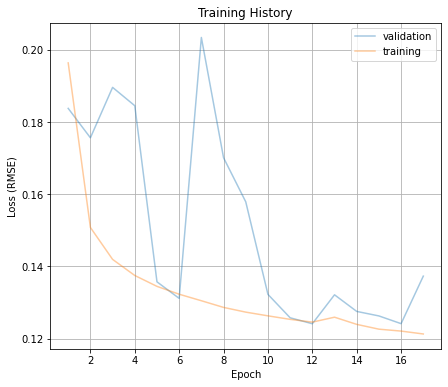

In [82]:
plt.figure(figsize=(7,6))
plt.title("Training History")
plt.plot(hist_df.index + 1, np.sqrt(hist_df["val_mse"]) ,alpha=0.4, label="validation")
plt.plot(hist_df.index + 1, np.sqrt(hist_df["mse"]) ,alpha=0.4, label="training")

plt.xlabel("Epoch")
plt.ylabel("Loss (RMSE)")
plt.legend()
plt.grid()
#plt.savefig("gen_loss.pdf")
#plt.savefig("gen_loss.png")

## Experimenting with cyclic learning rates

One method for improving the performance of our neural net is to schedule the learning rate to cycle between high and low learing rates. This allows the neural net to explore a wide range of parameter space, while also being able to take small steps to learn finer details.  Based on [Smith 2015](https://arxiv.org/pdf/1506.01186.pdf), I will set up a test neural net to cycle through a range of learning rates to determine where the loss performs best, and then schedule a cyclic learning rate over this interval, in efforts to improve the performance of my neural net. 

In [83]:
!git clone https://github.com/bckenstler/CLR
!git clone https://github.com/WittmannF/LRFinder

Cloning into 'CLR'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 252 (delta 1), reused 4 (delta 0), pack-reused 244
Receiving objects: 100% (252/252), 2.06 MiB | 27.74 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Cloning into 'LRFinder'...
remote: Enumerating objects: 71, done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 71
Unpacking objects: 100% (71/71), done.


In [84]:
from CLR.clr_callback import CyclicLR
from LRFinder.keras_callback import LRFinder

In [85]:
# configuration settings for LR finder
start_lr = 1e-4
end_lr = 1.5e0
no_epochs = 15

In [86]:
build_res_net = False

if build_res_net:
    train_batch = 256
    test_batch = int(train_batch/4)

    train_steps_epoch = int(np.ceil(len(train)/train_batch))
    test_steps_epoch = int(np.ceil(len(validation)/test_batch))


    train_generator = MyGen("reduced_training_images/", train, batch_size=train_batch, outtype="tensor")
    test_generator = MyGen("reduced_training_images/", validation, batch_size=test_batch, outtype="tensor")

    with tf.device('/gpu:0'):
        res_model = Sequential()

        res_model.add(tf.keras.applications.ResNet50(
            include_top=False,
            weights=None,
            input_tensor=tf.keras.layers.Input(shape=(75, 75,3)),
            input_shape=(75, 75, 3),
            pooling="max")
        )
        res_model.add(Dense(37, activation='sigmoid'))

        res_model.compile(optimizer="adam",
                  loss="mse", 
                  metrics=["mse", "categorical_crossentropy", "accuracy"])

        res_model.summary()

In [87]:
find_good_lrs = False

if find_good_lrs:
    # define LR finder callback
    lr_finder = LRFinder(min_lr=start_lr, max_lr=end_lr)

    # perform LR finder
    #res_model.fit(train_generator, test_generator, batch_size=batch_size, callbacks=[lr_finder], epochs=no_epochs)
    history_gen = res_model.fit(train_generator, 
                                steps_per_epoch=train_steps_epoch, 
                                epochs=no_epochs,
                                validation_data=test_generator,
                                validation_steps=test_steps_epoch,
                                callbacks=[lr_finder])

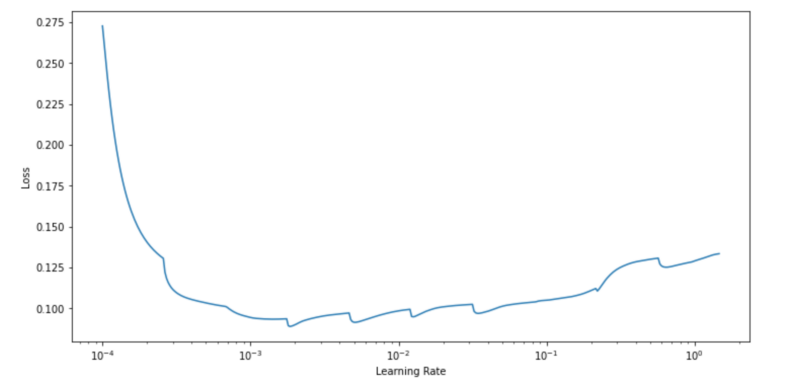

In [10]:
plt.figure(figsize=(14,7))
img = mpimg.imread("images/LR_vs_loss.png")
plt.axis('off')
plt.imshow(img);

The best learning rates appear to be between 1e-4 and 1e-2, so this will be the bounds on which we will set our learning rate for the cyclic learning rate scheduler. 

In [88]:
build_res_net = False

if build_res_net:
    train_batch = 256
    test_batch = int(train_batch/4)

    train_steps_epoch = int(np.ceil(len(train)/train_batch))
    test_steps_epoch = int(np.ceil(len(validation)/test_batch))


    train_generator = ImgAugment("training_images/", train, batch_size=train_batch, outtype="tensor")
    test_generator = ImgAugment("training_images/", validation, batch_size=test_batch, outtype="tensor")

    with tf.device('/gpu:0'):
        cyclic_model = Sequential()

        cyclic_model.add(tf.keras.applications.ResNet50(
            include_top=False,
            weights=None,
            input_tensor=tf.keras.layers.Input(shape=(75, 75,3)),
            input_shape=(75, 75, 3),
            pooling="max")
        )
        cyclic_model.add(Dense(37, activation='sigmoid'))

        cyclic_model.compile(loss="mse", 
                              optimizer="adam",
                              metrics=["mse", "accuracy", "categorical_crossentropy"])
        
        cyclic_model.summary()

In [89]:
run_model = False

if run_model:

    run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

    #define path to save model
    model_path = f"nn_results/datalab_nn_{run_time_string}.h5"
    print(f"Training ... {model_path}")

    logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    csv_logger = tf.keras.callbacks.CSVLogger(f"nn_results/training_{run_time_string}.log")

    earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_mse", min_delta=0.00001,
                                                patience=5, verbose=1, mode="auto")

    model_check = tf.keras.callbacks.ModelCheckpoint(model_path, 
                                                    monitor="val_mse", 
                                                    save_best_only=True,
                                                    verbose=1)
    
    # Set CLR options
    clr_step_size = train_steps_epoch
    base_lr = 1e-4
    max_lr = 1e-2
    mode = "triangular"

    # define the callback
    clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, step_size=clr_step_size, mode=mode)

    # fit data to model
    history = cyclic_model.fit(train_generator, 
                                steps_per_epoch=train_steps_epoch, 
                                epochs=20,
                                validation_data=test_generator,
                                validation_steps=test_steps_epoch,
                                callbacks=[clr,tensorboard_callback,csv_logger,model_check])
    

In [90]:
latest_log_file = "/content/drive/MyDrive/astro_128/cyclic_lr/training_2021-05-04T01_19.log"
hist_df = pd.read_csv(latest_log_file)
hist_df

epoch  accuracy  ...  val_loss   val_mse
0       0  0.592030  ...  0.074751  0.074751
1       1  0.670782  ...  0.038170  0.038170
2       2  0.716119  ...  0.055887  0.055887
3       3  0.736885  ...  0.012611  0.012611
4       4  0.746762  ...  0.024544  0.024544
5       5  0.751214  ...  0.010401  0.010401
6       6  0.768398  ...  0.017751  0.017751
7       7  0.767912  ...  0.013376  0.013376
8       8  0.775988  ...  0.019474  0.019474
9       9  0.780177  ...  0.009089  0.009089
10     10  0.784124  ...  0.020694  0.020694
11     11  0.781796  ...  0.008959  0.008959
12     12  0.787261  ...  0.011752  0.011752
13     13  0.788334  ...  0.008690  0.008690
14     14  0.795175  ...  0.012448  0.012448
15     15  0.776959  ...  0.018781  0.018781
16     16  0.791734  ...  0.014318  0.014318
17     17  0.796045  ...  0.008976  0.008976
18     18  0.806529  ...  0.015161  0.015161
19     19  0.802947  ...  0.008494  0.008494

[20 rows x 9 columns]

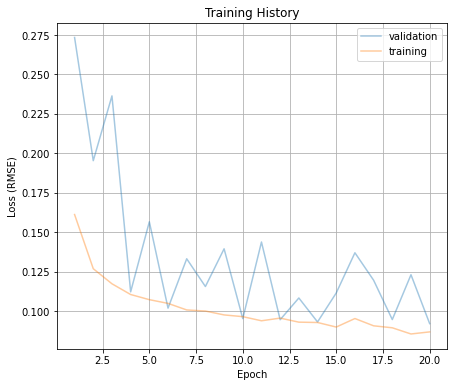

In [91]:
plt.figure(figsize=(7,6))
plt.title("Training History")
plt.plot(hist_df.index + 1, np.sqrt(hist_df["val_mse"]) ,alpha=0.4, label="validation")
plt.plot(hist_df.index + 1, np.sqrt(hist_df["mse"]) ,alpha=0.4, label="training")

plt.xlabel("Epoch")
plt.ylabel("Loss (RMSE)")
plt.legend()
plt.grid()
#plt.savefig("gen_loss.pdf")
#plt.savefig("gen_loss.png")

In [92]:
# cyclic_model.save("cyclic_augmented.h5", overwrite=False)

Now that we have run several neural nets, we will take a look at their performance and choose to use the best model to predict with. Below is a plot of the validation loss vs epoch, and the neural net with a loss closest to zero will be the model I use to predict labels with. 

In [93]:
prob_15 = DATADIR+"problem_15/training_2021-05-01T07_17.log"
prob_18 = DATADIR+"problem_18/training_2021-05-01T21_58.log"
prob_19 = DATADIR+"problem_19/training_2021-05-01T19_50.log"
prob_20 = DATADIR+"problem_20/training_2021-05-02T00_35.log"
cycling_lr = DATADIR+"cyclic_lr/training_2021-05-04T01_19.log"
cycling_augmentation = DATADIR+"cyclic_augmentation/training_2021-05-04T02_43.log"
rlr = DATADIR+"reduced_LR/training_2021-05-06T23_10.log"

tbl_15 = pd.read_csv(prob_15)
tbl_18 = pd.read_csv(prob_18)
tbl_19 = pd.read_csv(prob_19)
tbl_20 = pd.read_csv(prob_20)
cyc_lr = pd.read_csv(cycling_lr)
cyc_aug= pd.read_csv(cycling_augmentation)
reduced_lr = pd.read_csv(rlr)

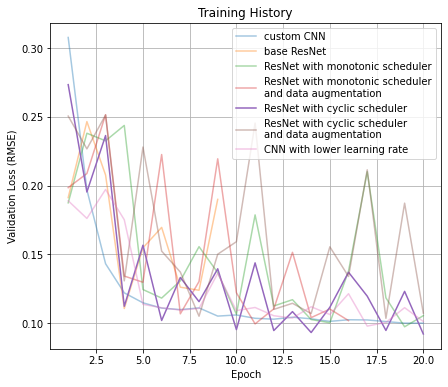

In [94]:
plt.figure(figsize=(7,6))
plt.title("Training History")
plt.plot(tbl_15.index + 1, np.sqrt(tbl_15["val_mse"]) ,alpha=0.4, label="custom CNN")
plt.plot(tbl_18.index + 1, np.sqrt(tbl_18["val_mse"]) ,alpha=0.4, label="base ResNet")
plt.plot(tbl_19.index + 1, np.sqrt(tbl_19["val_mse"]) ,alpha=0.4, label="ResNet with monotonic scheduler")
plt.plot(tbl_20.index + 1, np.sqrt(tbl_20["val_mse"]) ,alpha=0.4, label="ResNet with monotonic scheduler\nand data augmentation")
plt.plot(cyc_lr.index + 1, np.sqrt(cyc_lr["val_mse"]) ,alpha=1.0, label="ResNet with cyclic scheduler")
plt.plot(cyc_aug.index + 1, np.sqrt(cyc_aug["val_mse"]) ,alpha=0.4, label="ResNet with cyclic scheduler\nand data augmentation")
plt.plot(reduced_lr.index + 1, np.sqrt(reduced_lr["val_mse"]) ,alpha=0.4, label="CNN with lower learning rate")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss (RMSE)")
plt.legend()
plt.grid()
#plt.savefig("loss_vs_epoch.pdf");

From this plot, we can see that the ResNet with the cyclic scheduler performs the best (has the lowest loss), so this is the model with which I will predict the labels.



## Predicting labels from the current best model

In [95]:
# from google.colab import files 
# uploaded = files.upload()

In [96]:
validation_labels = validation["GalaxyID"]
len(validation), len(validation_labels)%128, len(validation)//128

(12316, 28, 96)

In [97]:
class PredGen:
    def __init__(self, path, tbl, start_index=0, batch_size=128, outtype="array"):
        self.path = path
        self.tbl = tbl
        self.index = start_index-1
        self.length = len(tbl)
        self.batch_size = batch_size
        self.outtype = outtype
        
    def __iter__(self):
        return self
    
    def __next__(self):
        # set the output shapes
        images = np.zeros((self.batch_size, 75, 75, 3))
        labels = np.zeros((self.batch_size, 38))
        for i in range(self.batch_size):
            self.index += 1
            if self.index >= self.length:
                # reset the index
                self.index = 0# raise StopIteration
                # rehuffle the table to randomize images
                self.tbl = self.tbl.sample(frac=1)
            source = self.tbl.iloc[self.index]
            images[i] = plt.imread(self.path+str(int(source["GalaxyID"]))+".jpg", format="jpg")/255.0
            labels[i] = np.asarray(source)
        if self.outtype == "tensor":
            return (K.constant(images), K.constant(labels))
        return (images, labels)

In [98]:
def predict_labels(predicting_model, predict_generator, batch_size=128, n_iterations=96):
    from tensorflow import keras
    #predicting_model = keras.models.load_model("res_net_train.h5")
    my_predictions = np.zeros((batch_size*n_iterations, 38))
    true_labels = np.zeros((batch_size*n_iterations, 38))
    entry_index = 0
    for i in range(n_iterations):
        next_batch = next(predict_generator)
        predicted_labels = predicting_model.predict(next_batch[0])
        batch_labels = next_batch[1]
        for j in range(len(predicted_labels)):
            my_predictions[entry_index, 0] = int(batch_labels[j, 0])
            my_predictions[entry_index, 1:] = predicted_labels[j]
            true_labels[entry_index, 0] = int(batch_labels[j, 0])
            true_labels[entry_index, 1:] = batch_labels[j, 1:]
            entry_index += 1
    return my_predictions, true_labels

In [99]:
predict_model = tf.keras.models.load_model("/content/drive/MyDrive/astro_128/cyclic_lr/cyclic_res_net.h5")

In [100]:
with tf.device('/gpu:0'):
    batch_size = 128
    n_iterations = 96
    predict_generator = PredGen("reduced_training_images/",validation, batch_size=batch_size, outtype="tensor")
    my_predictions, true_labels = predict_labels(predict_model, predict_generator)

In [101]:
def prediction_scatter_plots(my_predictions, validation):
    fig, ax = plt.subplots(8, 5, figsize=(18,18))
    index = 1
    for i in range(8):
        for j in range(5):
            if index < 38:
                #get data and generate plot
                data = np.zeros(len(my_predictions))
                true_labels = np.zeros(len(my_predictions))
                for k, prediction in enumerate(my_predictions):
                    data[k] = prediction[index]
                for k, label in enumerate(validation):
                    true_labels[k] = label[index]
                max_data = np.max(data)
                max_true = np.max(true_labels)
                the_biggest = max(max_data, max_true)
                x = np.linspace(0, the_biggest)
                ax[i,j].plot(x,x, color="black")
                ax[i,j].scatter(true_labels, data, s=1, alpha=0.5)
                ax[i,j].set_title(label_meanings[index])
                ax[i,j].set_xlabel("GalaxyZoo label")
                ax[i,j].set_ylabel("predicted label")
            index += 1
    ax[7,2].axis("off")
    ax[7,3].axis("off")
    ax[7,4].axis("off")
    plt.subplots_adjust(hspace=1)#, wspace=0)
    plt.tight_layout()

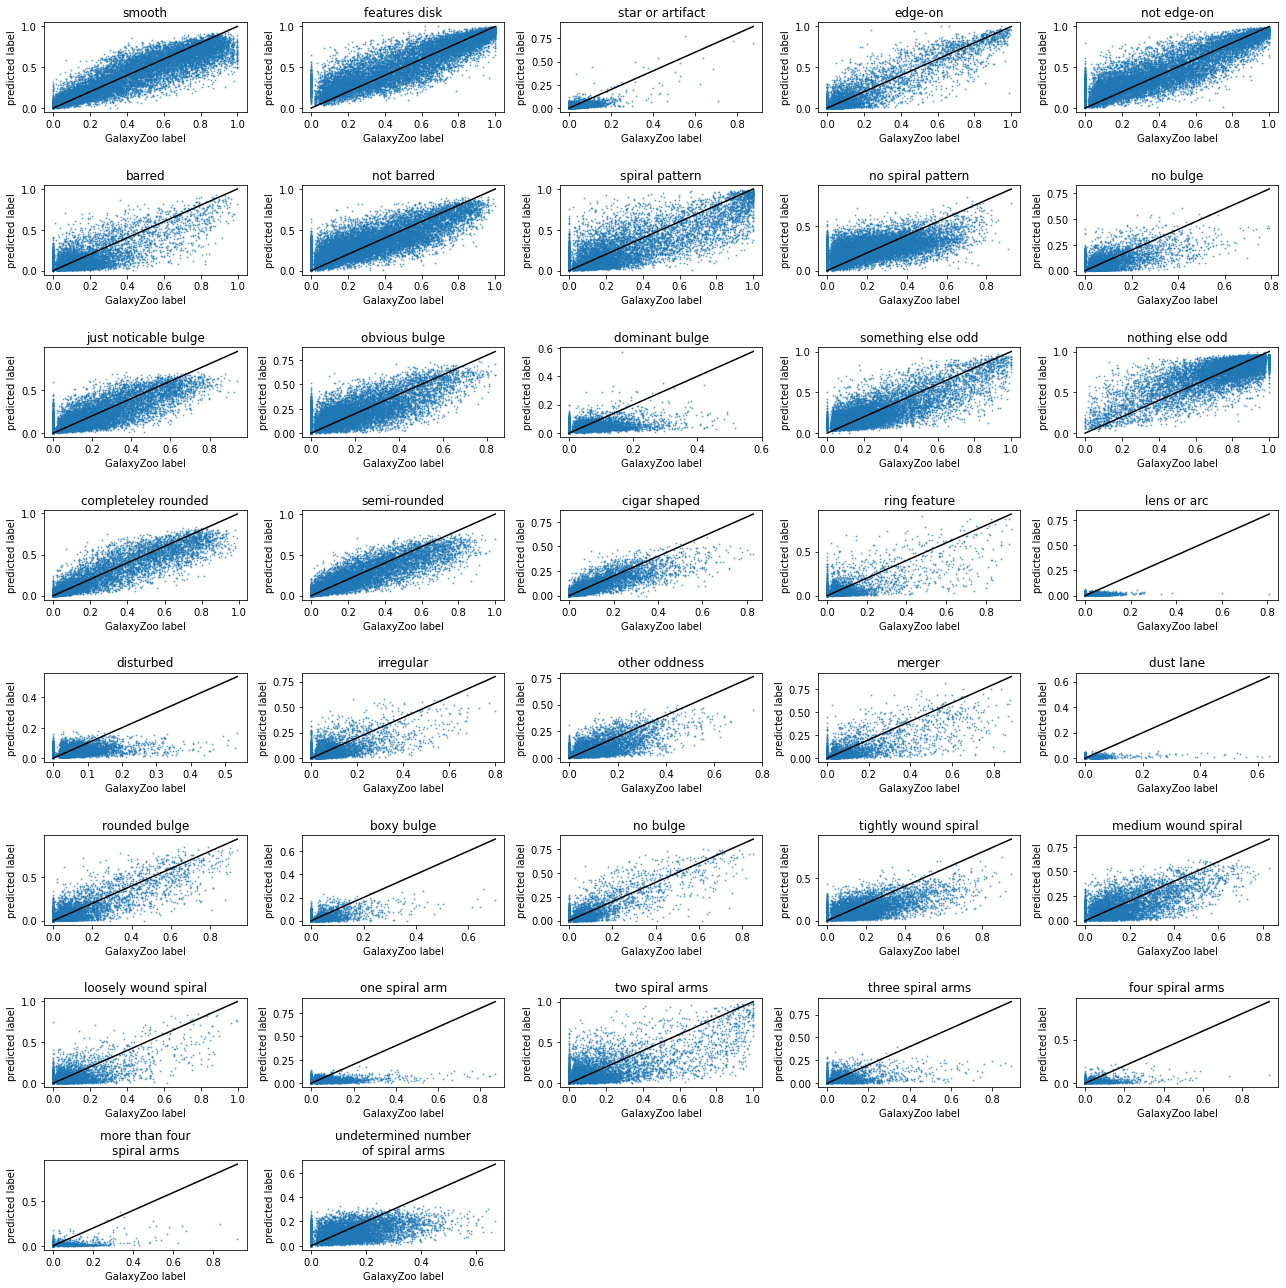

In [102]:
label_meanings.insert(0, "GalaxyID")
prediction_scatter_plots(my_predictions, true_labels)

#plt.savefig("predicted_vs_true.pdf")
#plt.savefig("predicted_vs_true.png")

In the above plots, I plotted the predicted labels against the GalaxyZoo labels, with a y=x line to indicate what perfect agreement would look like. As we can see, most of the labels (somewhat roughly) follow the y=x trend. However, there are several labels that my neural net does not perform well on. They are: star or artifact, lens or arc, dust lane, one, four, and more than four spiral arms. 

In [103]:
def prediction_histograms(my_predictions):
    fig, ax = plt.subplots(8, 5, figsize=(18,18))
    index = 1
    nbins = int(np.round(np.log(len(labels_tbl))/np.log(2))) + 1
    for i in range(8):
        for j in range(5):
            if index < 38:
                #get data and generate plot
                _ = ax[i,j].hist(my_predictions[:, index], bins=25)
                ax[i,j].set_title(label_meanings[index])
                ax[i,j].set_yscale('log')
            index += 1
    ax[7,2].axis("off")
    ax[7,3].axis("off")
    ax[7,4].axis("off")
    plt.subplots_adjust(hspace=1)#, wspace=0)
    plt.tight_layout()

predicted labels


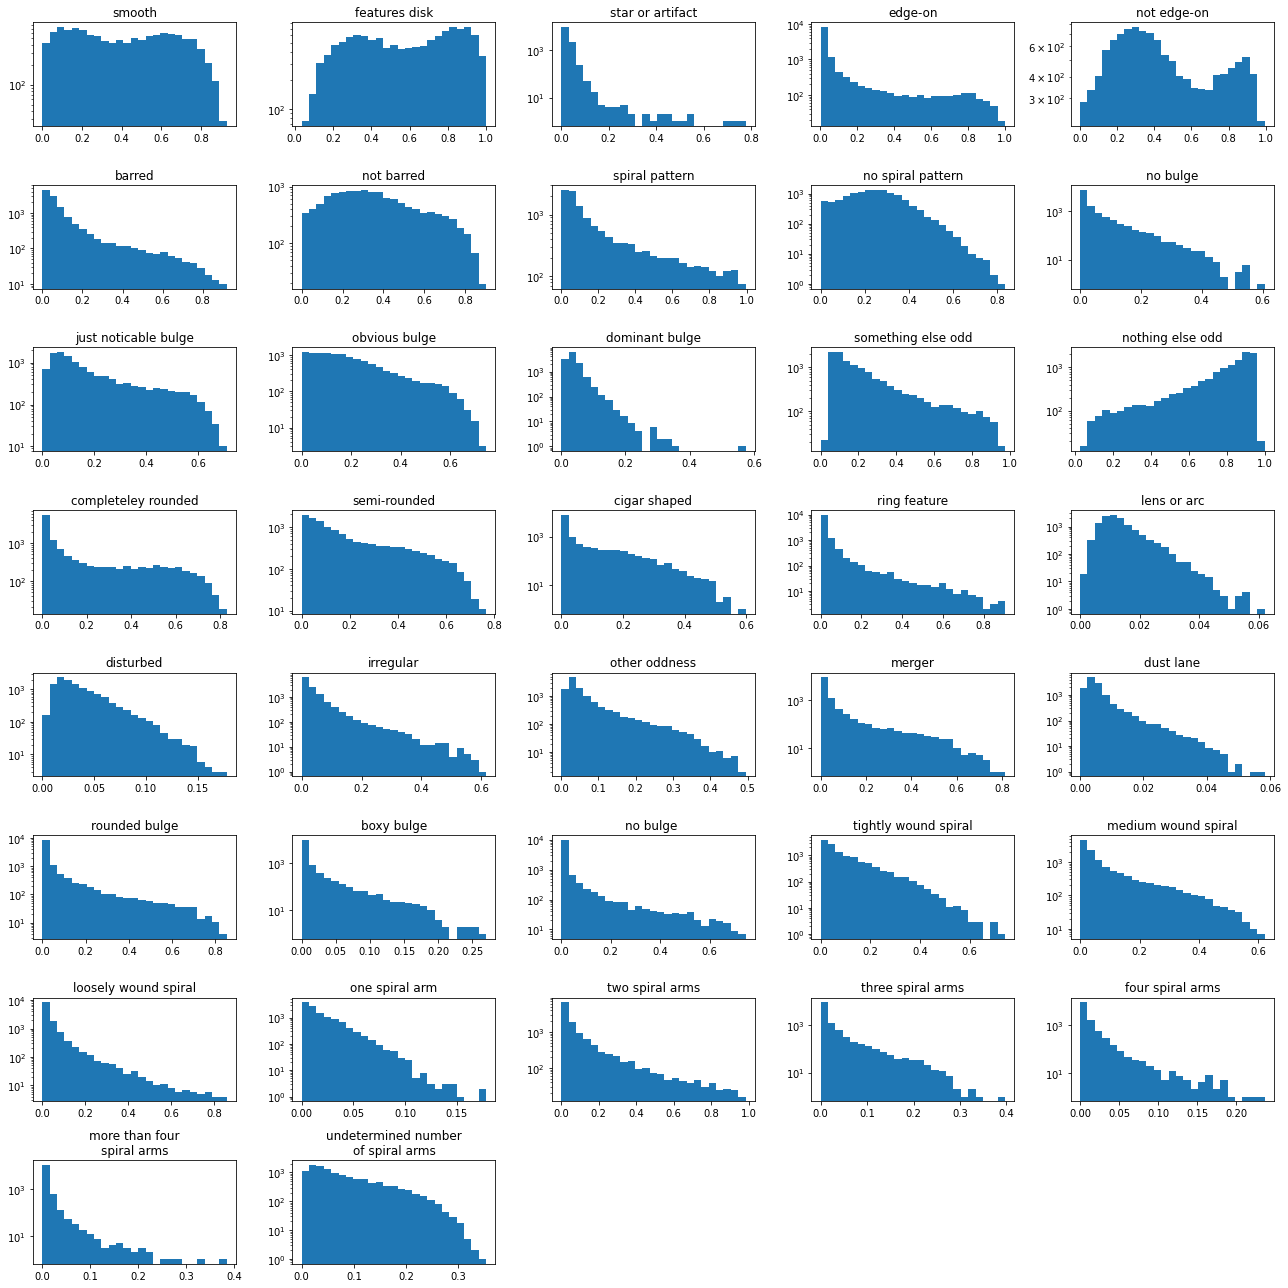

true labels


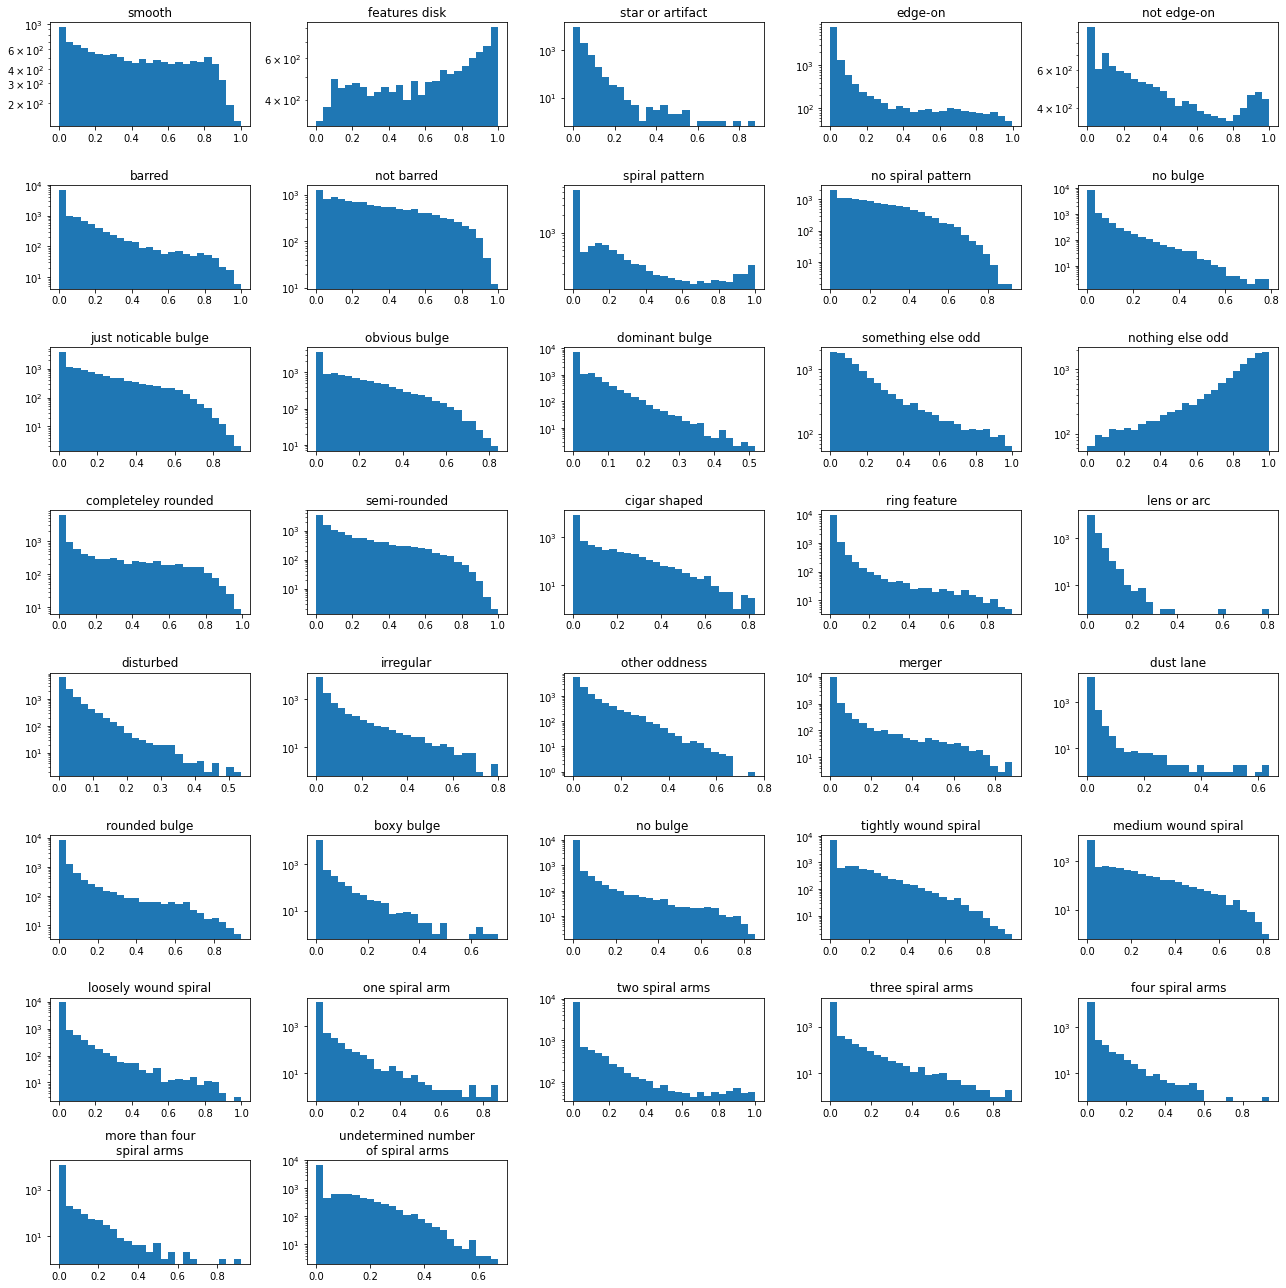

In [104]:
print("predicted labels")
prediction_histograms(my_predictions)
plt.show()
print("true labels")
prediction_histograms(true_labels)
#plt.savefig("prediction_hist.pdf")
#plt.savefig("prediction_hist.png")

## Examining Predictions

In [105]:
predictions_tbl = pd.DataFrame(my_predictions, columns=label_meanings)
true_tbl = pd.DataFrame(true_labels, columns=label_meanings)

In [106]:
def plot_top_five(tbl, labels, dir_path):
    fig, ax = plt.subplots(len(labels), 5, figsize=(15,3*len(labels)))
    for i, label in enumerate(labels):
        top_5 = tbl.sort_values(label, ascending=False).iloc[:5]
        for j in range(5):
            source_id = str(int(top_5.iloc[j]["GalaxyID"]))
            image = plt.imread(dir_path+source_id+".jpg")
            ax[i,j].set_title(label)
            ax[i,j].imshow(image)
            ax[i,j].axis("off")
    plt.tight_layout()


In [107]:
indices = [1,3,4,9,20,33,24]
plot_labels = []
for index in indices:
    plot_labels.append(label_meanings[index])

In order to test how well the model performs, we will plot the top five galaxies from the following labels: `smooth`, `star/artifact`, `edge-on disk`, `odd: ring`, `odd: lens/arc`, `spiral: 2 arms`, and `odd: merger`. The top five galaxies for each of these labels will be plotted according to the labels assigned by GalaxyZoo and the labels determined by the neural network. We will first examine the galaxies according to the GalaxyZoo labels. 

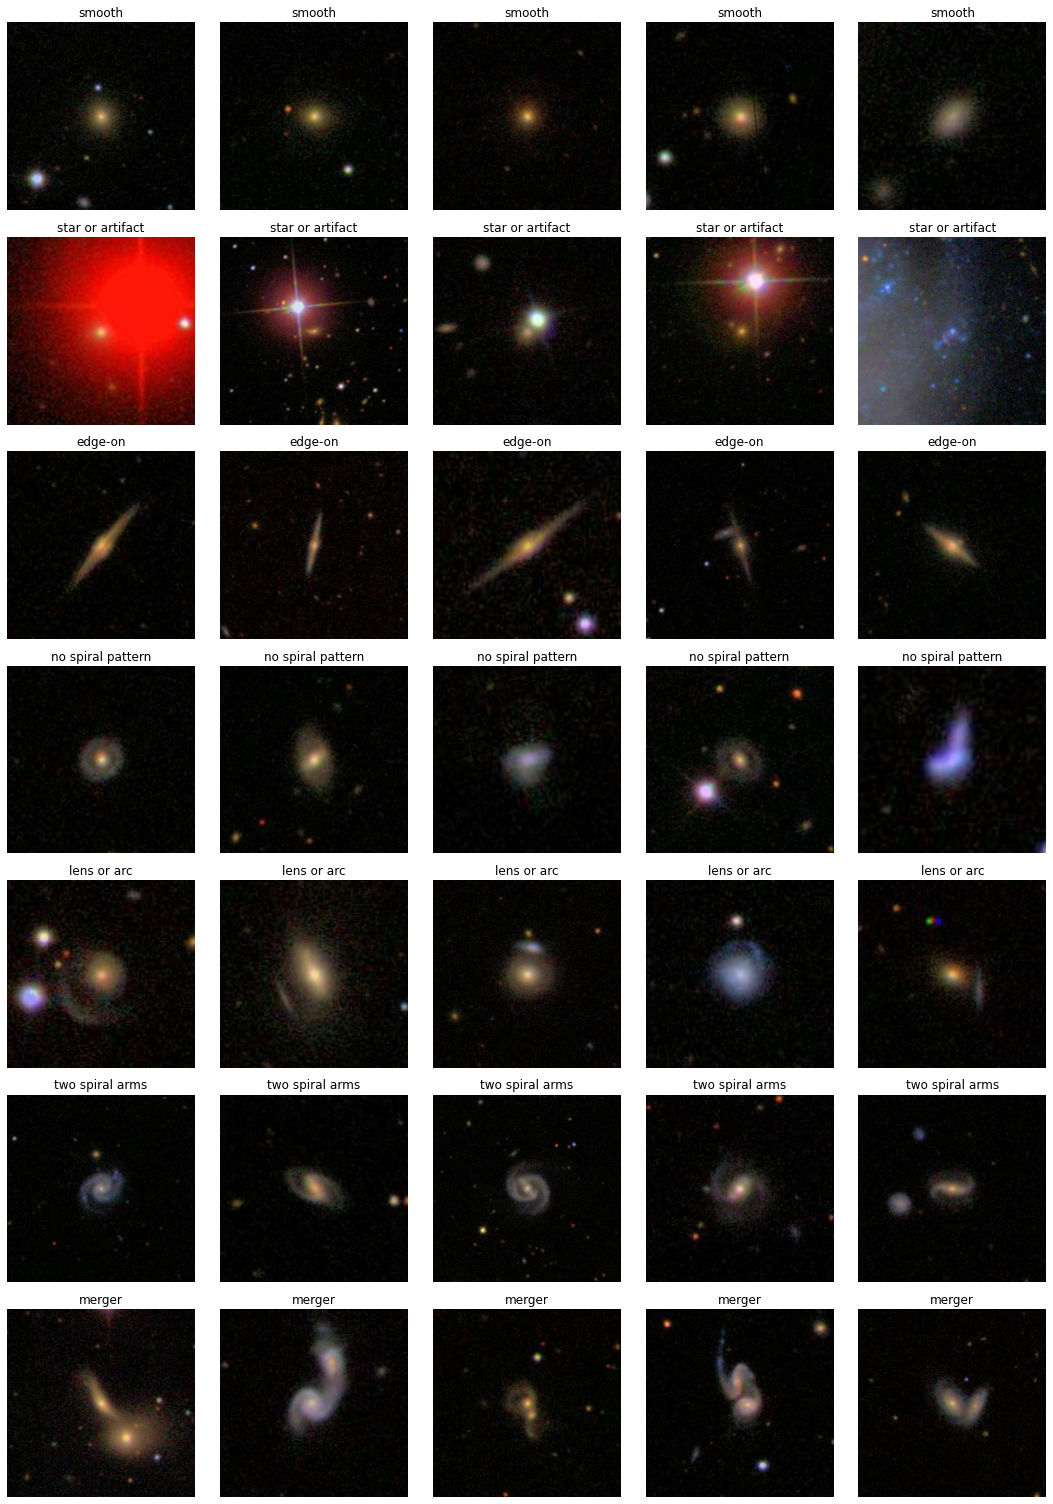

In [108]:
plot_top_five(true_tbl, plot_labels, "training_images/")

Now we will repeat the same plot, but now looking at the top five according to the labels determined by the neural net. 

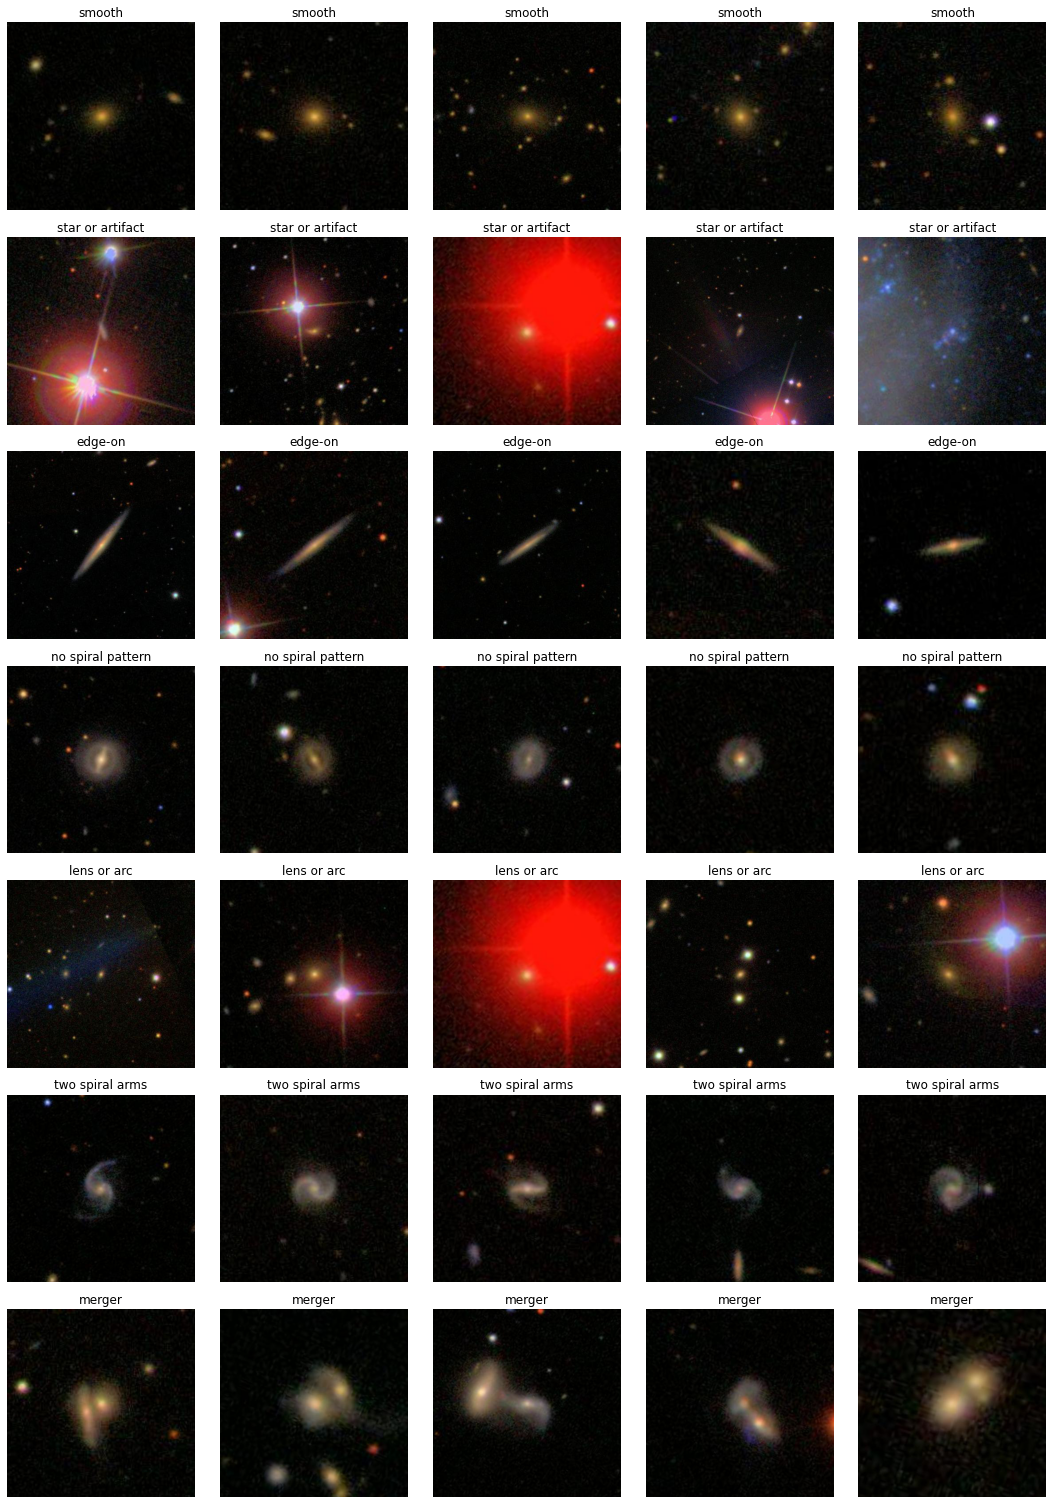

In [109]:
plot_top_five(predictions_tbl, plot_labels, "training_images/")

Looking at the top five images in these categories, we can see that there are some trends in the image identification. The neural net performs very well with recognizing the smooth galaxies and the star/artifact labels. When looking at the edge-on galaxies, it appears that my neural net perfers galaxies that are tilted $\pm 45$ degrees from being vertical. My neural also appears to falsely identify star/artifact images as lensing events, but in the rest of the images, it appers to perform well.

Looking at the correlation matrix below, we can see that the color scheme is similar to the correlation matrix of the training data, which is a good sign. However, there are stronger correlation relationships within the individual classes, than what was present in the training data. This could be indicative that the neural net is not aware of the decision dependencies, and as a result is classifying a galaxy as satisfying several labels within a single class. 

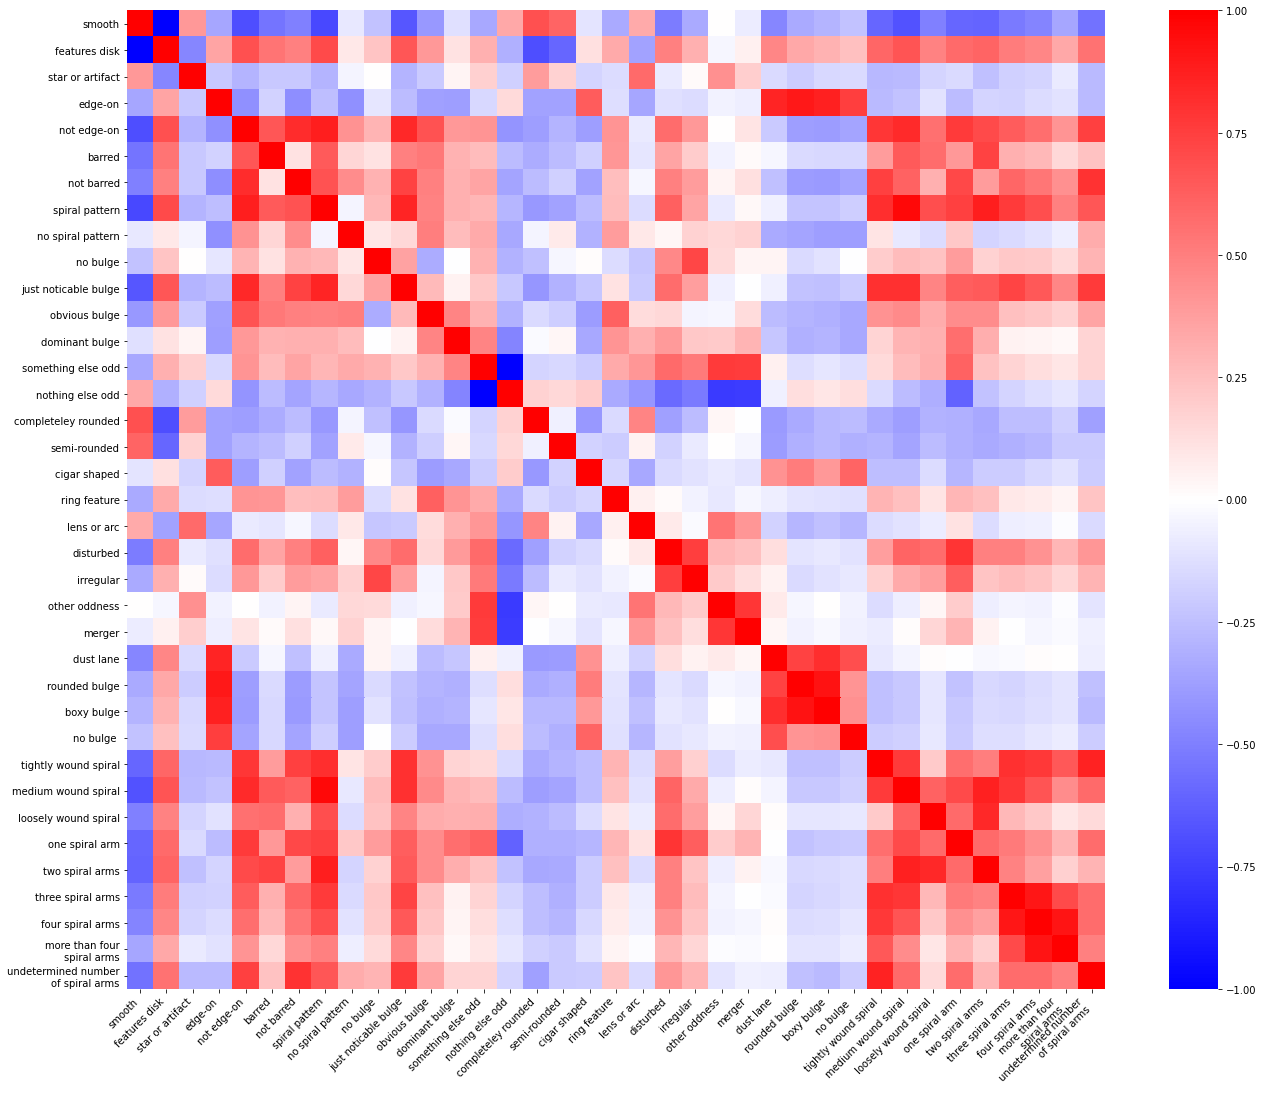

In [111]:
plot_correlation_matrix(predictions_tbl, subset=label_meanings[1:], height=18)

## Threshold confidence for merger

In [112]:
def top_of_range(tbl, value, step=0.1, max=False):
    if max:
        range = np.where((tbl["merger"] > value) & (tbl["merger"] < value+step))
        tbl = tbl.iloc[range]
        if len(tbl) > 0:
            return int(tbl.sort_values("merger", ascending=False).iloc[0][["GalaxyID"]])
        else:
          return None
    else:
        tbl = tbl[tbl["merger"] > value]
        if len(tbl) > 0:
            return int(tbl.sort_values("merger").iloc[0][["GalaxyID"]])
        else:
          return None

def plot_base_value(tbl, max=False):
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    index = 0
    for i in range(3):
        for j in range(3):
            #print("Searching for images above %s" % (index*0.1))
            source_id = top_of_range(tbl, index*0.1, max=max)
            if source_id is not None:
                file_path = "training_images/"+str(source_id)+".jpg"
                image = plt.imread(file_path)
                ax[i, j].imshow(image)
                ax[i,j].set_title(str(np.round(index*0.1, 1)))
            else:
                print(source_id)
                ax[i, j].axis("off")
            index+=1

def plot_fine_steps(tbl, start, step, max=False):
    fig, ax = plt.subplots(3,3, figsize=(10,10))
    index = 0
    for i in range(3):
        for j in range(3):
            source_id = top_of_range(tbl, start+index*step, max=max)
            if source_id is not None:
                file_path = "training_images/"+str(source_id)+".jpg"
                image = plt.imread(file_path)
                ax[i, j].imshow(image)
                ax[i,j].set_title(str(np.round(start+index*step, 2)))
            else:
                print(source_id)
                ax[i, j].axis("off")
            index+=1

Investigating the merger fraction, we can see that the galaxy with low label values are most likely just two galaxies that are angularly close, without actually being interacting gravitationally. As the label value increases, we start to see images of galaxies that are more reminiscent of what a merger would look like. At a label value of about 0.6, the pair of galaxies begins to look like they are interacting gravitationally, so we will investigate further to determine the second decimal place for the label value. Upon close examination, I have decided that the best label value is 0.61, which is what I will use as my confidence threshold for what constitutes a merger. 

This threshold seems reasonable to interpret as a probability. It seems reasonable to say that I am about 61% confident in the determination that this image contains a pair of galaxies that are merging. 

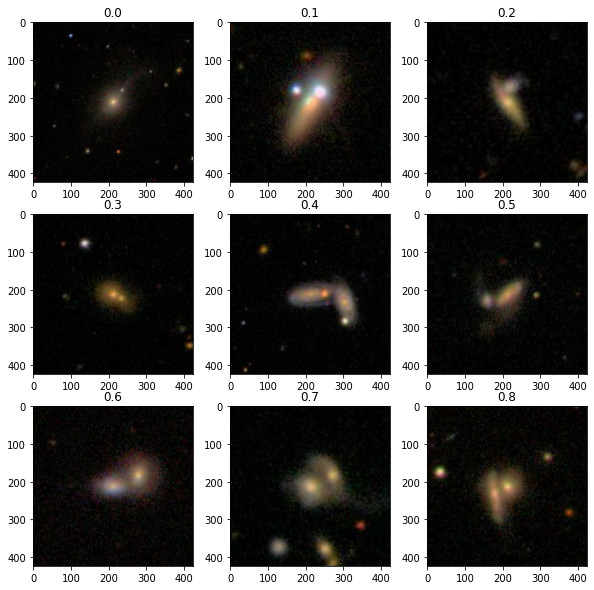

In [113]:
plot_base_value(predictions_tbl, max=True)

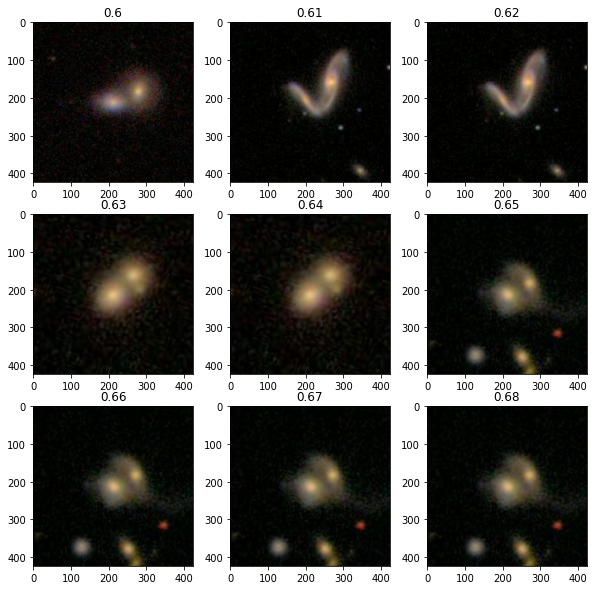

In [129]:
plot_fine_steps(predictions_tbl, 0.6, 0.01, max=True)

In [115]:
confidence_threshold = 0.61

## Examining the Test Data

Now I will run my trained model on the, as of yet, unseen training data and estimate the fraction of them that are considered mergers. I will then use the number of glaxies above this threshold (0.61) to determine the fractional merger rate of galaxies at z=0. 

In [116]:
!tar -xf /content/drive/MyDrive/astro_128/test_images.tar -C .
print("Done!")

Done!


In [117]:
# first we resize the test images to be 75x75
outdir = "reduced_test_images/"
check_directory(outdir)
all_test = glob.glob("test_images/*.jpg")
reduced_images = glob.glob("reduced_test_images/*.jpg")
if len(reduced_images) != len(all_test):
    for i in range(len(all_test)):
        reduce_and_save(all_test[i], cut_and_shred, outdir)

In [118]:
class TestGen:
    def __init__(self, paths, start_index=0, batch_size=128, outtype="array"):
        self.paths = paths
        self.index = start_index-1
        self.length = len(paths)
        self.batch_size = batch_size
        self.outtype = outtype
        
    def __iter__(self):
        return self
    
    def __next__(self):
        # set the output shapes
        images = np.zeros((self.batch_size, 75, 75, 3))
        labels = np.zeros(self.batch_size)
        for i in range(self.batch_size):
            self.index += 1
            if self.index >= self.length:
                try:
                    remaining = self.length%self.batch_size
                    if self.outtype == "tensor":
                        return (K.constant(images[:remaining]), K.constant(labels[:remaining]))
                    return (images[:remaining], labels[:remaining])
                except:
                    raise StopIteration
            source = self.paths[self.index]
            images[i] = plt.imread(source, format="jpg")/255.0
            labels[i] = int(os.path.basename(source).split(".")[0])
        if self.outtype == "tensor":
            return (K.constant(images), K.constant(labels))
        return (images, labels)

In [119]:
all_reduced_test = glob.glob("reduced_test_images/*jpg")
temp = TestGen(all_reduced_test, batch_size=1)

In [120]:
def predict_test_labels(predicting_model, predict_generator, batch_size=128, n_iterations=96):
    from tensorflow import keras
    #predicting_model = keras.models.load_model("res_net_train.h5")
    my_predictions = np.zeros((batch_size*n_iterations, 38))
    entry_index = 0
    for i in range(n_iterations):
        next_batch = next(predict_generator)
        predicted_labels = predicting_model.predict(next_batch[0])
        batch_labels = next_batch[1]
        for j in range(len(predicted_labels)):
            my_predictions[entry_index, 0] = int(batch_labels[j])
            my_predictions[entry_index, 1:] = predicted_labels[j]
            entry_index += 1
    return pd.DataFrame(my_predictions, columns=label_meanings)

In [121]:
all_reduced_test = glob.glob("reduced_test_images/*.jpg")
len(all_reduced_test)

79975

In [122]:
with tf.device('/gpu:0'):
    test_generator = TestGen(all_reduced_test, batch_size=128, outtype="tensor")
    test_predictions = predict_test_labels(predict_model, test_generator, batch_size=128, n_iterations=625)

In [123]:
is_merging = test_predictions[test_predictions["merger"] > confidence_threshold]
print("Fraction of mergers:  ",(len(is_merging)/len(test_predictions)))

Fraction of mergers:   0.0021375


Looking at the fractional merger rate from [Lotz et al, 2011](https://arxiv.org/abs/1108.2508), it appears that my estimate is about an order of magnitude lower than the 0.02-0.04 fractional merger rate presented in Figure 13. There are some potential explanations for the difference between the Lotz' reported value and my inferred value. The most obvious difference is that the fractional merger rate in Lotz et al. has units of [merger]$Gyr^{-1}$, whereas my value is a fraction of observed galaxies. To make the units match, I would need to convert the count of galaxies into a time-dependant rate, so that a more useful comparison can be made. 